In [2]:
%pip install pandas numpy==1.26.4 nltk transformers matplotlib wordcloud tf-keras

  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl (15.9 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 2.0.2 which is incompatible.


In [ ]:
# Librerías de manipulación de datos
import pandas as pd
import numpy as np

# Librerías para preprocesamiento de texto
import re
import unicodedata
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

# Librerías para análisis de sentimientos con BERT
from transformers import pipeline

# Librerías para visualización
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Librerías para Topic modeling
import re

c:\Users\ASUS\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\ASUS\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Importación de la data

In [6]:
# Cargar la tabla completa
# combined_reviews = pd.read_sql("SELECT * FROM combined_reviews", con=engine)

# # Filtrar en Python
# filtered_reviews = combined_reviews.groupby('Modelo estandar').filter(lambda x: x['comentario'].nunique() >= 200)

# # Guardar la tabla filtrada nuevamente en MySQL
# filtered_reviews.to_sql('filtered_reviews', con=engine, if_exists='replace', index=False)

In [7]:
#Cargar los datos
df= pd.read_csv(r"..\SQL Queries\filtered_reviews.csv")
print(df.info())  # Resumen del DataFrame
print(df['calificacion'].value_counts())  # Distribución de calificaciones

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9620 entries, 0 to 9619
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   comentario       9553 non-null   object
 1   calificacion     9620 non-null   int64 
 2   codigo           9620 non-null   object
 3   Enlace           7456 non-null   object
 4   Sitio Web        9620 non-null   object
 5   Marca            9620 non-null   object
 6   Modelo estandar  9620 non-null   object
 7   Precio           9620 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 601.4+ KB
None
calificacion
5    8622
4     697
3     152
1      99
2      50
Name: count, dtype: int64


1. Pre-procesamiento del Texto

1.1 Limpieza Básica

In [8]:
# Descargar recursos de NLTK
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Configurar stopwords y lematización
stop_words = set(stopwords.words('spanish'))
lemmatizer = WordNetLemmatizer()

# Stopwords personalizadas
important_negatives = {"no", "nunca", "sin", "muy", "poco", "bastante", "mas", "dos", "mucho"}
stop_words = stop_words - important_negatives

# Diccionario de correcciones específicas
correcciones = {
    "q": "que", "exelente": "excelente", "espectativas": "expectativas", "celu": "celular",
    "bno": "bueno", "auriculare": "auriculares", "cel": "celular", "sultra": "ultra",
    "aprox": "aproximadamente", "mobil": "movil", "amooo": "amo", "perfeccoon": "perfeccion",
    "camras": "camaras", "escojer": "escoger", "encamta": "encanta", "aser": "hacer",
    "calentarce": "calentarse", "parese": "parece", "nuy": "muy", "okey": "okay",
    "espetativas": "expectativas", "pq": "por que", "mut": "muy", "ecxelente": "excelente",
    "execelente": "excelente", "bna": "buena", "redimiento": "rendimiento", "qe": "que",
    "encata": "encanta", "sobrecalienta": "calienta", "buenardo": "bueno", "demaciado": "demasiado",
    "(Esta reseña se ha recibido a través de una promoción.)": ""
}

# Función para eliminar tildes sin alterar estructura
def remove_accents(text):
    accents = {'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u',
               'Á': 'A', 'É': 'E', 'Í': 'I', 'Ó': 'O', 'Ú': 'U'}
    for accented_char, unaccented_char in accents.items():
        text = text.replace(accented_char, unaccented_char)
    return text

# Función para aplicar correcciones específicas (con conversión a minúsculas)
def aplicar_correcciones(text):
    tokens = text.split()
    corrected_tokens = [correcciones.get(token.lower(), token) for token in tokens]
    return ' '.join(corrected_tokens)

# Función para eliminar frases específicas antes de procesar
def eliminar_frase(text):
    return text.replace("(Esta reseña se ha recibido a través de una promoción.)", "")

# Función de limpieza básica con lematización
def clean_text_with_lemmatization(text):
    text = eliminar_frase(text)  
    text = remove_accents(text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\d+', '', text)
    text = aplicar_correcciones(text) 
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Función de limpieza básica sin lematización
def clean_text_without_lemmatization(text):
    text = eliminar_frase(text) 
    text = remove_accents(text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\d+', '', text)
    text = aplicar_correcciones(text) 
    return text

# Rellenar valores NaN en la columna 'comentario' con una cadena vacía
df['comentario'] = df['comentario'].fillna('')

# Crear columnas adicionales
df['comentario_limpio'] = df['comentario'].apply(clean_text_with_lemmatization)
df['comentario_limpio_sin_lematizar'] = df['comentario'].apply(clean_text_without_lemmatization)

# Verificar cambios
print("Primeros comentarios limpios en el DataFrame:")
print(df[['comentario', 'comentario_limpio', 'comentario_limpio_sin_lematizar']].head())

# Eliminar filas duplicadas basadas en todas las columnas excepto "Enlace"
df = df.drop_duplicates(subset=[col for col in df.columns if col != 'Enlace'])




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Primeros comentarios limpios en el DataFrame:
                                          comentario  \
0  Si corresponde a la foto tiene un excelente re...   
1  El tamaño es el apropiado y para cargar fácilm...   
2  Muy buen producto a un excelente precio, llego...   
3            Me gusto mucho, y fue rápido la llegada   
4         Cumple lo que promete, es un lindo celular   

                                   comentario_limpio  \
0  si corresponde foto excelente rendimiento capa...   
1  tamaño apropiado cargar facilmente calidad ima...   
2  muy buen producto excelente precio llego rapid...   
3                         gusto mucho rapido llegada   
4                       cumple promete lindo celular   

                     comentario_limpio_sin_lematizar  
0  Si corresponde a la foto tiene un excelente re...  
1  El tamaño es el apropiado y para cargar facilm...  
2  Muy buen producto a un excelente precio llego ...  
3             Me gusto mucho y fue rapido la llegada  
4    

1.2 Asignación de Sentimiento con BERT 

In [11]:

# Configurar el modelo preentrenado de Hugging Face para análisis de sentimientos
analizador_sentimientos = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Función para clasificar un comentario con BERT
def clasificar_sentimiento_bert(comentario):
    try:
        resultado = analizador_sentimientos(comentario)
        # Extraer la etiqueta de calificación (e.g., '5 stars' → 5)
        return int(resultado[0]['label'][0])
    except Exception as e:
        print(f"Error procesando el comentario: {comentario}. Error: {e}")
        return None

# Aplicar el modelo a la columna de comentarios limpios
df['Calificacion Predicha'] = df['comentario_limpio_sin_lematizar'].apply(clasificar_sentimiento_bert)

# Clasificar en polaridad (opcional)
def polaridad_desde_calificacion(calificacion):
    if calificacion >= 4:
        return "Positivo"
    elif calificacion == 3:
        return "Neutro"
    elif calificacion > 0:  # Filtrar posibles None
        return "Negativo"
    else:
        return None

# Crear la columna de polaridad
df['Sentimiento'] = df['Calificacion Predicha'].apply(polaridad_desde_calificacion)

# Verificar resultados
print(df[['comentario_limpio_sin_lematizar', 'Calificacion Predicha', 'Sentimiento']].head())


tf_model.h5:   0%|          | 0.00/670M [00:00<?, ?B/s]

c:\Users\ASUS\anaconda3\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ASUS\.cache\huggingface\hub\models--nlptown--bert-base-multilingual-uncased-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use 0


                     comentario_limpio_sin_lematizar  Calificacion Predicha  \
0  Si corresponde a la foto tiene un excelente re...                      5   
1  El tamaño es el apropiado y para cargar facilm...                      4   
2  Muy buen producto a un excelente precio llego ...                      5   
3             Me gusto mucho y fue rapido la llegada                      5   
4          Cumple lo que promete es un lindo celular                      4   

  Sentimiento  
0    Positivo  
1    Positivo  
2    Positivo  
3    Positivo  
4    Positivo  


In [8]:
#Guardar df en un archivo CSV
#df.to_csv(r"d:\Proyecto Web Scrapping\Analisis de Sentimientos\sentiment_analysis.csv", index=False)

2. Análisis Básico

2.1 Calificaciones por Marca y Modelo

Análisis por marca:
         Total_Comentarios  Calificacion_Promedio         1         2  \
Marca                                                                   
Apple                 2352               4.881378  1.020408  0.127551   
Samsung               4583               4.843334  1.003709  0.676413   
Xiaomi                1733               4.759377  1.154068  0.403924   

                3          4          5  
Marca                                    
Apple    1.360544   4.676871  92.814626  
Samsung  1.701942   6.218634  90.399302  
Xiaomi   1.673399  14.887478  81.881131  


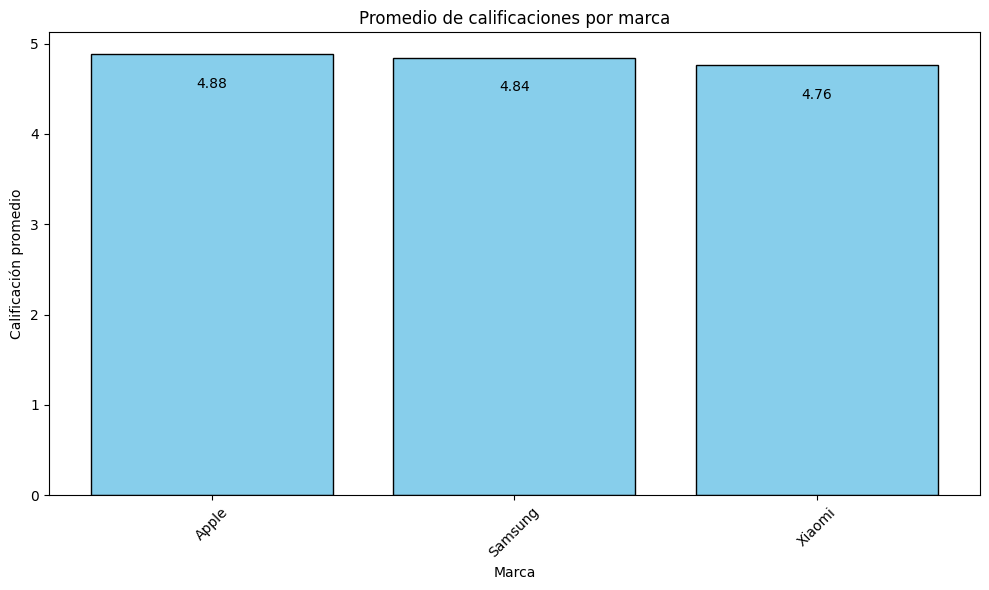

In [9]:
# Calcular la distribución por marca
distribucion_marca = df.groupby('Marca').agg(
    Total_Comentarios=('calificacion', 'count'),
    Calificacion_Promedio=('calificacion', 'mean')
)

# Proporción de calificaciones por marca
proporcion_calificaciones = df.groupby(['Marca', 'calificacion']).size().unstack(fill_value=0)
proporcion_calificaciones = proporcion_calificaciones.div(proporcion_calificaciones.sum(axis=1), axis=0) * 100

# Unir ambas tablas
analisis_marca = distribucion_marca.join(proporcion_calificaciones)

# Mostrar resultados
print("Análisis por marca:")
print(analisis_marca)

# Visualización con calificaciones promedio dentro de las barras
fig, ax = plt.subplots(figsize=(10, 6))

# Gráfico de barras
bars = ax.bar(
    analisis_marca.index,  # Índice de marcas
    analisis_marca['Calificacion_Promedio'],  # Promedio de calificaciones
    color='skyblue', edgecolor='black'
)

# Añadir texto dentro de las barras
for bar in bars:
    height = bar.get_height()  # Altura de cada barra
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # Posición horizontal centrada en la barra
        height - 0.4,  # Ajustar la posición vertical más abajo
        f"{height:.2f}",  # Calificación promedio con 2 decimales
        ha='center', va='bottom', fontsize=10, color='black'
    )

# Personalizar el gráfico
ax.set_title("Promedio de calificaciones por marca")
ax.set_xlabel("Marca")
ax.set_ylabel("Calificación promedio")
ax.set_xticks(range(len(analisis_marca.index)))
ax.set_xticklabels(analisis_marca.index, rotation=45)
plt.tight_layout()
plt.show()


Análisis por modelo:
                               Total_Comentarios  Calificacion_Promedio  \
Modelo estandar                                                           
IPhone 11                                   1078               4.985158   
IPhone 13                                    437               4.855835   
IPhone 14                                    563               4.783304   
IPhone 15                                    274               4.715328   
Samsung Galaxy A15                           563               4.589698   
Samsung Galaxy A25                           288               4.385417   
Samsung Galaxy A35                           250               4.620000   
Samsung Galaxy A55                          1866               4.967310   
Samsung S24 Ultra                           1616               4.904703   
Xiaomi Poco X6 Pro                           309               4.812298   
Xiaomi Redmi 13C                             250               4.776000   
Xiao

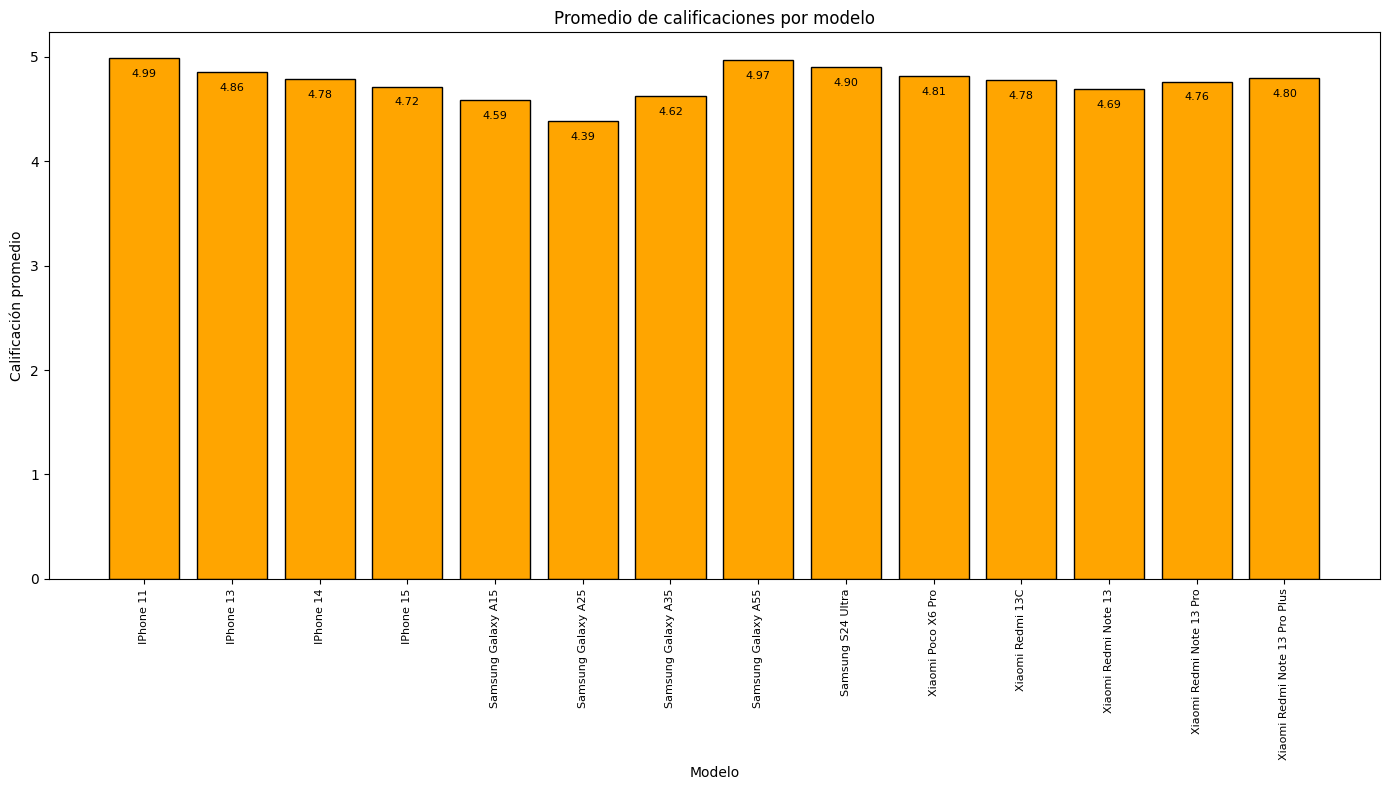

In [10]:
# Calcular la distribución por modelo
distribucion_modelo = df.groupby('Modelo estandar').agg(
    Total_Comentarios=('calificacion', 'count'),
    Calificacion_Promedio=('calificacion', 'mean')
)

# Proporción de calificaciones por modelo
proporcion_calificaciones_modelo = df.groupby(['Modelo estandar', 'calificacion']).size().unstack(fill_value=0)
proporcion_calificaciones_modelo = proporcion_calificaciones_modelo.div(proporcion_calificaciones_modelo.sum(axis=1), axis=0) * 100

# Unir ambas tablas
analisis_modelo = distribucion_modelo.join(proporcion_calificaciones_modelo)

# Mostrar resultados
print("Análisis por modelo:")
print(analisis_modelo)

# Visualización con calificaciones promedio dentro de las barras
fig, ax = plt.subplots(figsize=(14, 8))  # Aumentar el tamaño para que sea más legible

# Gráfico de barras
bars = ax.bar(
    analisis_modelo.index,  # Índice de modelos
    analisis_modelo['Calificacion_Promedio'],  # Promedio de calificaciones
    color='orange', edgecolor='black'
)

# Añadir texto dentro de las barras
for bar in bars:
    height = bar.get_height()  # Altura de cada barra
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # Posición horizontal centrada en la barra
        height - 0.2,  # Ajustar la posición vertical más abajo
        f"{height:.2f}",  # Calificación promedio con 2 decimales
        ha='center', va='bottom', fontsize=8, color='black'
    )

# Personalizar el gráfico
ax.set_title("Promedio de calificaciones por modelo")
ax.set_xlabel("Modelo")
ax.set_ylabel("Calificación promedio")
ax.set_xticks(range(len(analisis_modelo.index)))
ax.set_xticklabels(analisis_modelo.index, rotation=90, fontsize=8)  # Rotar etiquetas 90° para más claridad
plt.tight_layout()
plt.show()


2.2 Calificación promedio y Precio

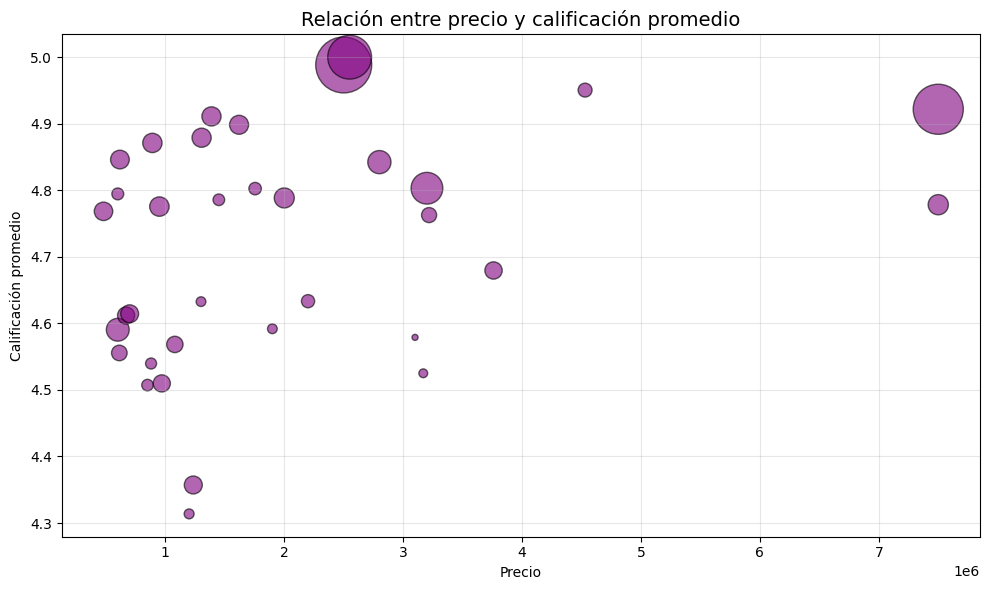

In [11]:
# Relación entre precio y calificación promedio
relacion_precio_calificacion = df.groupby('Precio').agg(
    Calificacion_Promedio=('calificacion', 'mean'),
    Total_Comentarios=('calificacion', 'count')
).reset_index()

# Visualización: Precio vs Calificación promedio
plt.figure(figsize=(10, 6))
plt.scatter(relacion_precio_calificacion['Precio'], relacion_precio_calificacion['Calificacion_Promedio'],
            s=relacion_precio_calificacion['Total_Comentarios'], alpha=0.6, color='purple', edgecolor='black')
plt.title("Relación entre precio y calificación promedio", fontsize=14)
plt.xlabel("Precio")
plt.ylabel("Calificación promedio")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


3. Análisis de Sentimientos

3.1 Relación entre Calificación Real y Sentimiento

Conteo de calificaciones reales y predichas:
   Calificacion Real  Sentimiento
1                 90          250
2                 41          148
3                139          443
4                653         1449
5               7745         6378


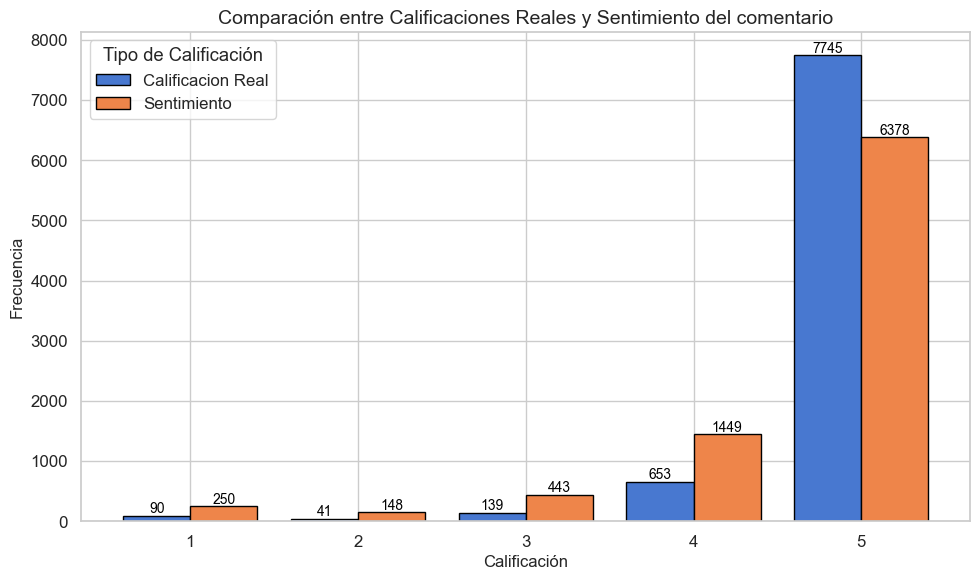

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Contar las calificaciones reales y predichas
calificaciones_reales = df['calificacion'].value_counts().sort_index()
calificaciones_predichas = df['Calificacion Predicha'].value_counts().sort_index()

# Crear un DataFrame para las comparaciones
comparacion_df = pd.DataFrame({
    'Calificacion Real': calificaciones_reales,
    'Sentimiento': calificaciones_predichas
}).fillna(0).astype(int)  # Reemplazar NaN con 0 y asegurar enteros

# Mostrar la tabla
print("Conteo de calificaciones reales y predichas:")
print(comparacion_df)

# Visualización: Gráfico de barras
plt.figure(figsize=(10, 6))
ax = comparacion_df.plot(kind='bar', width=0.8, edgecolor='black', ax=plt.gca())
plt.title("Comparación entre Calificaciones Reales y Sentimiento del comentario", fontsize=14)
plt.xlabel("Calificación", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.xticks(rotation=0)  # Mantener etiquetas horizontales
plt.legend(title="Tipo de Calificación")

# Anotar valores sobre las barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.tight_layout()
plt.show()


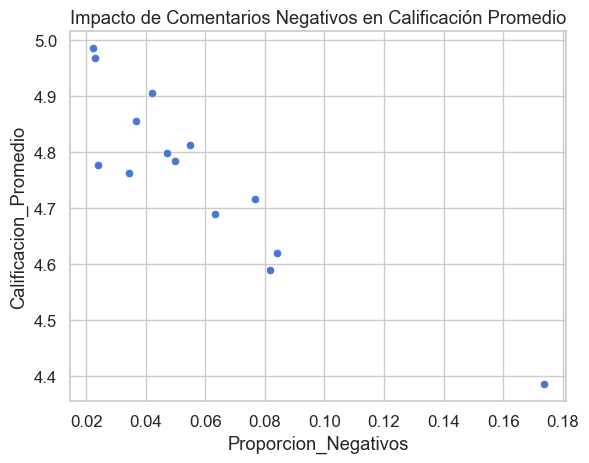

In [13]:
# Proporción de negativos por modelo
negativos_por_modelo = df[df['Sentimiento'] == 'Negativo'].groupby('Modelo estandar')['Sentimiento'].count()
total_reviews_por_modelo = df.groupby('Modelo estandar')['Sentimiento'].count()
proporcion_negativos = (negativos_por_modelo / total_reviews_por_modelo).sort_values(ascending=False)

# Combinar con calificaciones promedio
calificaciones_modelo = df.groupby('Modelo estandar')['calificacion'].mean()
impacto_negativos = pd.concat([proporcion_negativos, calificaciones_modelo], axis=1)
impacto_negativos.columns = ['Proporcion_Negativos', 'Calificacion_Promedio']

# Visualizar
sns.scatterplot(data=impacto_negativos, x='Proporcion_Negativos', y='Calificacion_Promedio')
plt.title("Impacto de Comentarios Negativos en Calificación Promedio")
plt.show()

3.2 Distribución del Sentimiento por Modelo y Marca

Proporción de sentimientos por marca (%):
Sentimiento  Negativo    Neutro   Positivo
Marca                                     
Apple        3.784014  4.974490  91.241497
Samsung      4.974907  4.516692  90.508401
Xiaomi       4.673976  6.866705  88.459319


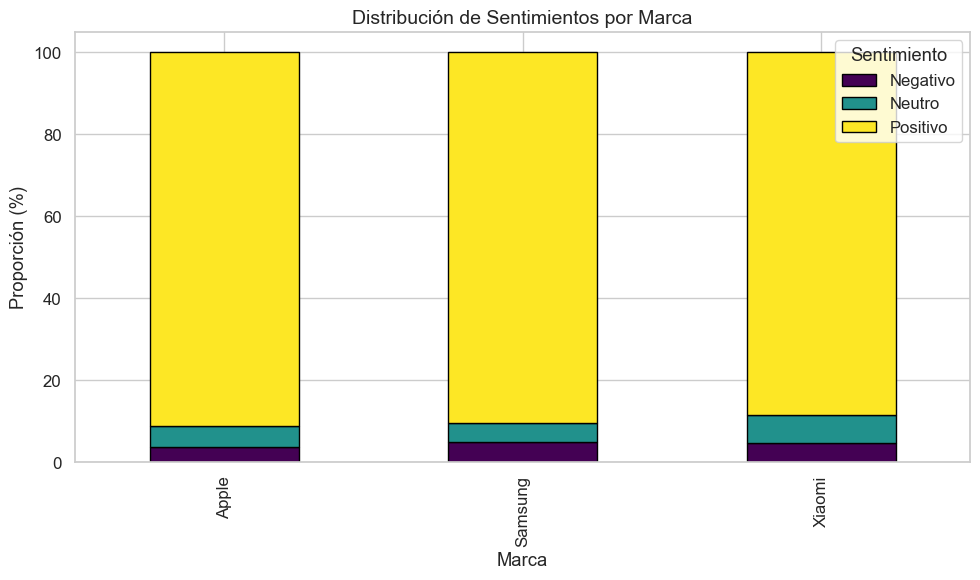

In [14]:
# Resumen de sentimientos por marca
sentimientos_marca = df.groupby('Marca')['Sentimiento'].value_counts(normalize=True).unstack() * 100

# Imprimir proporción de sentimientos por marca
print("Proporción de sentimientos por marca (%):")
print(sentimientos_marca)

# Visualización: Barras apiladas
sentimientos_marca.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    colormap='viridis',
    edgecolor='black'
)
plt.title("Distribución de Sentimientos por Marca", fontsize=14)
plt.xlabel("Marca")
plt.ylabel("Proporción (%)")
plt.legend(title="Sentimiento")
plt.tight_layout()
plt.show()


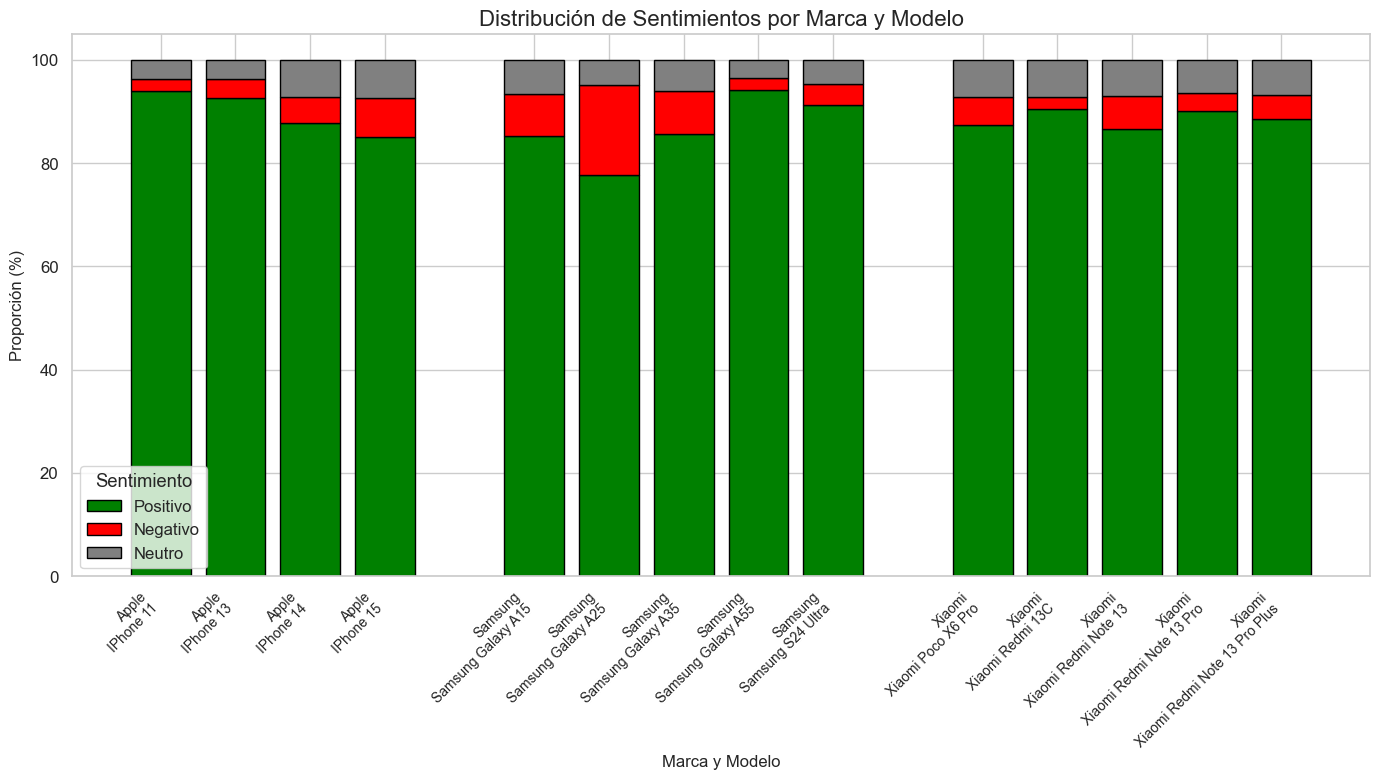

In [15]:
# Calcular proporciones de sentimientos por modelo
sentimientos_modelo = df.groupby(['Marca', 'Modelo estandar'])['Sentimiento'].value_counts(normalize=True).unstack() * 100

# Ordenar los modelos dentro de cada marca
sentimientos_modelo = sentimientos_modelo.reset_index().sort_values(by=['Marca', 'Modelo estandar'])


# Configuración del gráfico
marcas = sentimientos_modelo['Marca'].unique()
colores = {'Positivo': 'green', 'Negativo': 'red', 'Neutro': 'gray'}
x_pos = 0  # Posición inicial en el eje X
x_ticks = []  # Almacenar las posiciones de las etiquetas
x_labels = []  # Almacenar las etiquetas de los modelos

plt.figure(figsize=(14, 8))

# Dibujar barras para cada marca y sus modelos
for marca in marcas:
    # Filtrar los datos por marca
    data_marca = sentimientos_modelo[sentimientos_modelo['Marca'] == marca]
    modelos = data_marca['Modelo estandar']
    
    # Dibujar barras para cada modelo
    for _, row in data_marca.iterrows():
        bottom = 0  # Altura inicial de las barras apiladas
        for sentimiento in ['Positivo', 'Negativo', 'Neutro']:
            if sentimiento in row:
                plt.bar(x_pos, row[sentimiento], bottom=bottom, color=colores[sentimiento], edgecolor='black', width=0.8)
                bottom += row[sentimiento]
        x_ticks.append(x_pos)
        x_labels.append(f"{marca}\n{row['Modelo estandar']}")
        x_pos += 1
    
    # Añadir un espacio extra entre marcas
    x_pos += 1

# Personalizar gráfico
plt.title("Distribución de Sentimientos por Marca y Modelo", fontsize=16)
plt.ylabel("Proporción (%)", fontsize=12)
plt.xlabel("Marca y Modelo", fontsize=12)
plt.xticks(x_ticks, x_labels, rotation=45, ha='right', fontsize=10)
plt.legend(labels=colores.keys(), title="Sentimiento")
plt.tight_layout()
plt.show()


3.3 Análisis de Frecuencia y Palabras Clave

Nube de Palabras y Frecuencias

Palabras positivas más comunes:
[('calidad', 1370), ('camara', 1157), ('rapido', 837), ('precio', 749), ('bateria', 695), ('samsung', 572), ('pantalla', 460), ('fotos', 436), ('tamaño', 425), ('movil', 406)]

Palabras negativas más comunes:
[('bateria', 70), ('samsung', 52), ('cargador', 50), ('pantalla', 48), ('camara', 34), ('carga', 31), ('rapido', 27), ('calidad', 24), ('fotos', 23), ('despues', 21)]


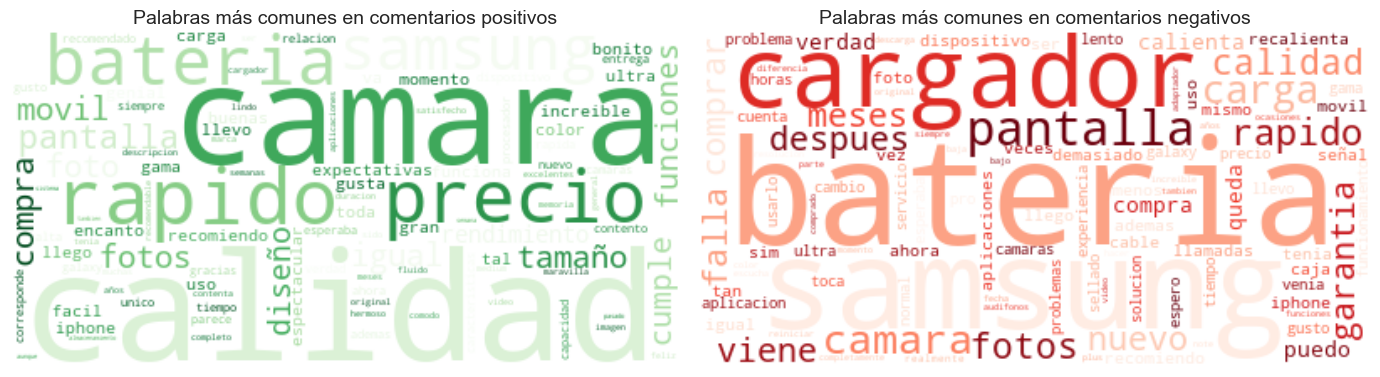

In [16]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Lista de palabras irrelevantes adicionales
excluir = {"no", "nunca", "sin", "muy", "poco", "bastante", "mas", "dos", "mucho", 
    "producto", "smartphone", "compre", "celular", "hace", "si", "solo", 
    "ma", "telefono", "equipo", "me", "dia", "dura", "aun", "trae",
    "asi", "do", "salio", "usar", "buena", "bien", "bueno", "buen", "malo", "mala", "excelente", "s", "g", 
    "encanta", "perfecto", "super", "mejor"}

# Filtrar comentarios por polaridad
comentarios_positivos = df[df['Sentimiento'] == 'Positivo']['comentario_limpio']
comentarios_negativos = df[df['Sentimiento'] == 'Negativo']['comentario_limpio']

# Tokenizar palabras excluyendo las irrelevantes
palabras_positivas = [word for word in " ".join(comentarios_positivos).split() if word not in excluir]
palabras_negativas = [word for word in " ".join(comentarios_negativos).split() if word not in excluir]

# Contar palabras más comunes
frecuencias_positivas = Counter(palabras_positivas)
frecuencias_negativas = Counter(palabras_negativas)

# Mostrar las 10 palabras más comunes (opcional)
print("Palabras positivas más comunes:")
print(frecuencias_positivas.most_common(10))

print("\nPalabras negativas más comunes:")
print(frecuencias_negativas.most_common(10))

# Crear nubes de palabras
wordcloud_positiva = WordCloud(
    background_color='white',
    max_words=100,
    colormap='Greens'
).generate_from_frequencies(frecuencias_positivas)

wordcloud_negativa = WordCloud(
    background_color='white',
    max_words=100,
    colormap='Reds'
).generate_from_frequencies(frecuencias_negativas)

# Visualización de las nubes de palabras
plt.figure(figsize=(14, 7))

# Nube de palabras positiva
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positiva, interpolation='bilinear')
plt.title("Palabras más comunes en comentarios positivos", fontsize=14)
plt.axis('off')

# Nube de palabras negativa
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negativa, interpolation='bilinear')
plt.title("Palabras más comunes en comentarios negativos", fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()


Palabras más comunes en comentarios negativos:
     Palabra  Frecuencia
0    bateria          70
1    samsung          52
2   cargador          50
3   pantalla          48
4     camara          34
5      carga          31
6     rapido          27
7    calidad          24
8      fotos          23
9    despues          21
10  garantia          20
11     nuevo          20
12     meses          20
13     viene          19
14     falla          19


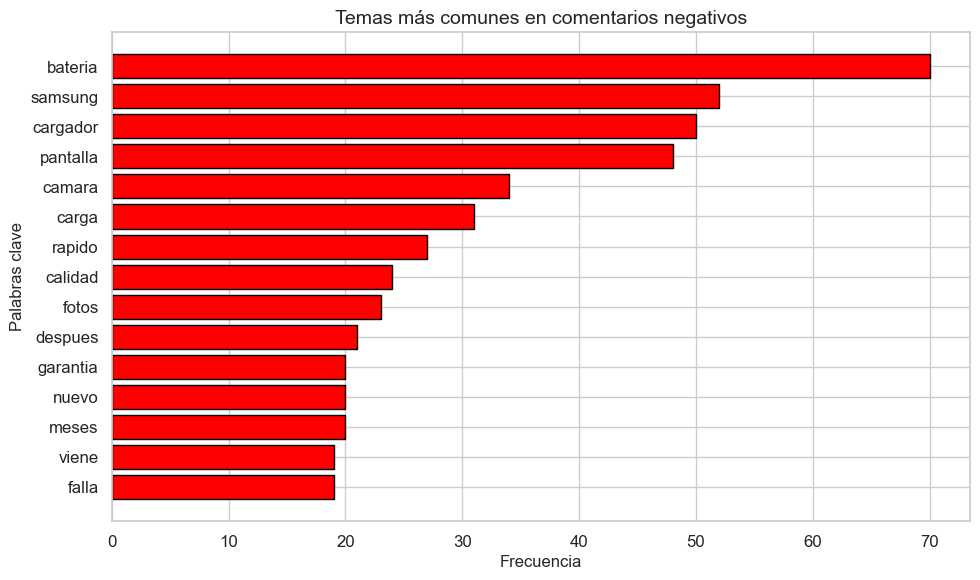

In [17]:
# Lista de palabras irrelevantes adicionales
excluir_negativos = excluir 
# Filtrar comentarios negativos
comentarios_negativos = df[df['Sentimiento'] == 'Negativo']['comentario_limpio']

# Tokenizar palabras excluyendo las irrelevantes
palabras_negativas = [word for word in " ".join(comentarios_negativos).split() if word not in excluir_negativos]

# Contar palabras más comunes
frecuencias_negativas = Counter(palabras_negativas).most_common(15)  # Las 15 palabras más frecuentes

# Crear un DataFrame para facilitar la visualización
import pandas as pd
df_quejas = pd.DataFrame(frecuencias_negativas, columns=['Palabra', 'Frecuencia'])

# Imprimir las 15 palabras más frecuentes en comentarios negativos
print("Palabras más comunes en comentarios negativos:")
print(df_quejas)

# Visualización: Gráfico de barras horizontales
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(df_quejas['Palabra'], df_quejas['Frecuencia'], color='red', edgecolor='black')
plt.xlabel("Frecuencia", fontsize=12)
plt.ylabel("Palabras clave", fontsize=12)
plt.title("Temas más comunes en comentarios negativos", fontsize=14)
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()


Palabras más comunes en comentarios positivos:
      Palabra  Frecuencia
0     calidad        1370
1      camara        1157
2      rapido         837
3      precio         749
4     bateria         695
5     samsung         572
6    pantalla         460
7       fotos         436
8      tamaño         425
9       movil         406
10       foto         385
11      igual         382
12     compra         381
13  funciones         337
14     diseño         329


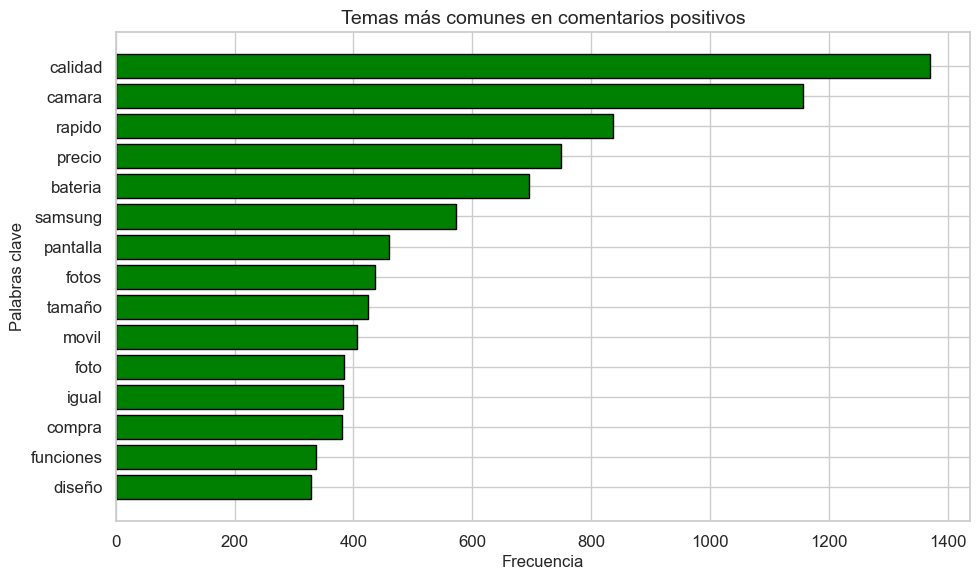

In [18]:
# Lista de palabras irrelevantes adicionales
excluir_positivos = excluir 

# Filtrar comentarios positivos
comentarios_positivos = df[df['Sentimiento'] == 'Positivo']['comentario_limpio']

# Tokenizar palabras excluyendo las irrelevantes
palabras_positivas = [word for word in " ".join(comentarios_positivos).split() if word not in excluir_positivos]

# Contar palabras más comunes
frecuencias_positivas = Counter(palabras_positivas).most_common(15)  # Las 15 palabras más frecuentes

# Crear un DataFrame para facilitar la visualización
df_positivos = pd.DataFrame(frecuencias_positivas, columns=['Palabra', 'Frecuencia'])

# Imprimir las 15 palabras más frecuentes en comentarios positivos
print("Palabras más comunes en comentarios positivos:")
print(df_positivos)

# Visualización: Gráfico de barras horizontales
plt.figure(figsize=(10, 6))
plt.barh(df_positivos['Palabra'], df_positivos['Frecuencia'], color='green', edgecolor='black')
plt.xlabel("Frecuencia", fontsize=12)
plt.ylabel("Palabras clave", fontsize=12)
plt.title("Temas más comunes en comentarios positivos", fontsize=14)
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()


3.4 Bigramas y Trigramas

Bigramas

In [19]:
# Listas de palabras para aplicar las reglas
excluir_bigramas_duplicados = {"buen", "bueno", "buena","buenas", "muy", "no", "mucho", "bien", "excelente"}
excluir_bigramas_totales = {"telefono", "compre", "aproximadamente", "hace", "do", "aun", "meses", "samsung","s", "ultra"}

# Función para filtrar bigramas según las reglas
def filtrar_bigramas(bigrama):
    palabras = bigrama.split()
    # Excluir bigramas con más de una palabra de "excluir_bigramas_duplicados"
    if len([p for p in palabras if p in excluir_bigramas_duplicados]) > 1:
        return False
    # Excluir bigramas con palabras en "excluir_bigramas_totales"
    if any(p in excluir_bigramas_totales for p in palabras):
        return False
    return True

# Función para procesar bigramas
def procesar_bigramas(comentarios):
    # Crear bigramas usando CountVectorizer
    vectorizer = CountVectorizer(ngram_range=(2, 2), min_df=5, stop_words=None)  # Configura el rango para bigramas
    X = vectorizer.fit_transform(comentarios)
    
    # Extraer los bigramas y sus frecuencias
    bigramas = vectorizer.get_feature_names_out()
    frecuencias = X.sum(axis=0).A1
    
    # Crear un DataFrame para facilitar el manejo
    df_bigramas = pd.DataFrame({'Bigrama': bigramas, 'Frecuencia': frecuencias})
    
    # Aplicar filtros
    df_bigramas = df_bigramas[df_bigramas['Bigrama'].apply(filtrar_bigramas)]
    
    # Ordenar por frecuencia descendente
    df_bigramas = df_bigramas.sort_values(by='Frecuencia', ascending=False).head(15)
    return df_bigramas

# Procesar comentarios negativos
comentarios_negativos = df[df['Sentimiento'] == 'Negativo']['comentario_limpio']
df_bigramas_negativos = procesar_bigramas(comentarios_negativos)

# Verificar el resultado
print("Bigramas más comunes en comentarios negativos:")
print(df_bigramas_negativos)

# Procesar comentarios positivos
comentarios_positivos = df[df['Sentimiento'] == 'Positivo']['comentario_limpio']
df_bigramas_positivos = procesar_bigramas(comentarios_positivos)

# Verificar el resultado
print("Bigramas más comunes en comentarios positivos:")
print(df_bigramas_positivos)


Bigramas más comunes en comentarios negativos:
          Bigrama  Frecuencia
36        no trae          17
1    bateria dura          16
29        no dura          14
34  no recomiendo          12
27     muy rapido          12
33       no puedo          11
44  trae cargador          10
25      muy lento           9
4      celular no           9
11       dura dia           8
32       no gusto           8
2      bateria no           8
39   queda pegado           7
28       no carga           7
45      verdad no           7
Bigramas más comunes en comentarios positivos:
                Bigrama  Frecuencia
123       buena calidad         426
611  excelente producto         359
111       buen producto         288
780          igual foto         240
580   excelente calidad         207
217      calidad precio         203
994          muy rapido         198
124        buena camara         197
106         buen equipo         187
53         bateria dura         160
591    excelente equipo       

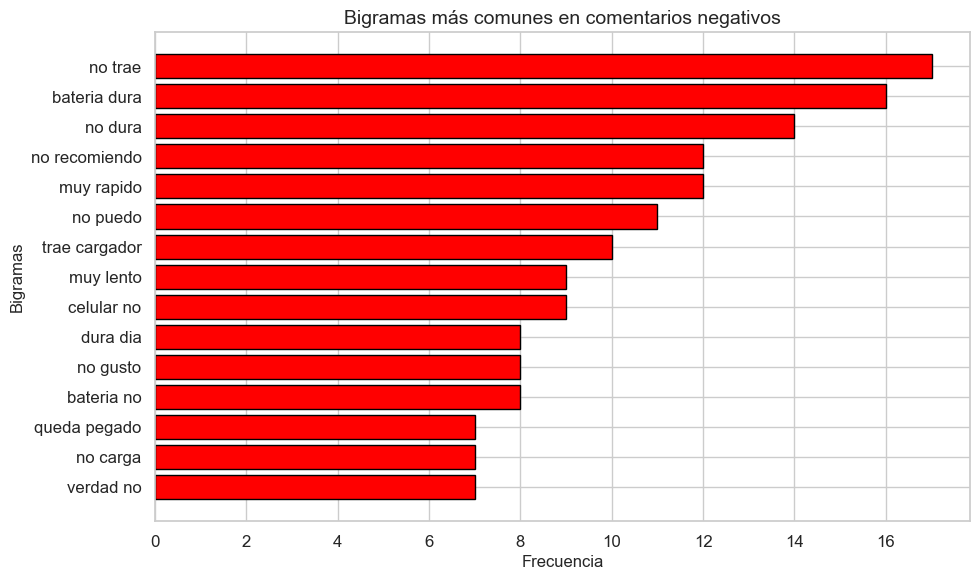

In [20]:
plt.figure(figsize=(10, 6))
plt.barh(df_bigramas_negativos['Bigrama'].astype(str), df_bigramas_negativos['Frecuencia'], color='red', edgecolor='black')
plt.xlabel("Frecuencia", fontsize=12)
plt.ylabel("Bigramas", fontsize=12)
plt.title("Bigramas más comunes en comentarios negativos", fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

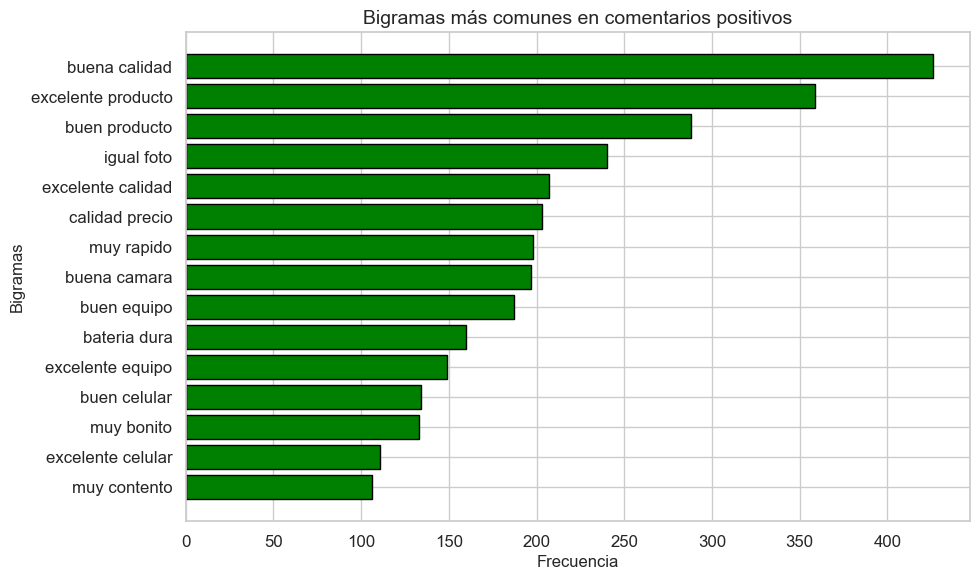

In [21]:
# Visualización de los bigramas positivos
plt.figure(figsize=(10, 6))
plt.barh(df_bigramas_positivos['Bigrama'].astype(str), df_bigramas_positivos['Frecuencia'], color='green', edgecolor='black')
plt.xlabel("Frecuencia", fontsize=12)
plt.ylabel("Bigramas", fontsize=12)
plt.title("Bigramas más comunes en comentarios positivos", fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Trigramas

In [22]:
# Lista de palabras para excluir completamente
excluir_trigramas_totales = {"telefono", "compre", "aproximadamente", "hace"}

# Función para filtrar trigramas según las reglas
def filtrar_trigramas(trigrama):
    palabras = trigrama.split()
    # Excluir trigramas con palabras en "excluir_trigramas_totales"
    if any(p in excluir_trigramas_totales for p in palabras):
        return False
    return True

# Función para procesar trigramas
def procesar_trigramas(comentarios):
    # Crear trigramas usando CountVectorizer
    vectorizer = CountVectorizer(ngram_range=(3, 3), min_df=5, stop_words=None)  # Configura el rango para trigramas
    X = vectorizer.fit_transform(comentarios)
    
    # Extraer los trigramas y sus frecuencias
    trigramas = vectorizer.get_feature_names_out()
    frecuencias = X.sum(axis=0).A1
    
    # Crear un DataFrame para facilitar el manejo
    df_trigramas = pd.DataFrame({'Trigrama': trigramas, 'Frecuencia': frecuencias})
    
    # Aplicar filtros
    df_trigramas = df_trigramas[df_trigramas['Trigrama'].apply(filtrar_trigramas)]
    
    # Ordenar por frecuencia descendente
    df_trigramas = df_trigramas.sort_values(by='Frecuencia', ascending=False).head(15)
    return df_trigramas

# Procesar comentarios negativos
comentarios_negativos = df[df['Sentimiento'] == 'Negativo']['comentario_limpio']
df_trigramas_negativos = procesar_trigramas(comentarios_negativos)

# Verificar el resultado
print("Trigramas más comunes en comentarios negativos:")
print(df_trigramas_negativos)

# Procesar comentarios positivos
comentarios_positivos = df[df['Sentimiento'] == 'Positivo']['comentario_limpio']
df_trigramas_positivos = procesar_trigramas(comentarios_positivos)

# Verificar el resultado
print("Trigramas más comunes en comentarios positivos:")
print(df_trigramas_positivos)


Trigramas más comunes en comentarios negativos:
           Trigrama  Frecuencia
5  no trae cargador          10
0   bateria no dura           6
4      muy lento no           6
Trigramas más comunes en comentarios positivos:
                     Trigrama  Frecuencia
310         muy buena calidad         157
303         muy buen producto         124
299           muy buen equipo          93
403   relacion calidad precio          76
297          muy buen celular          75
100          camara muy buena          64
220         funciona muy bien          55
311          muy buena camara          48
386        producto me pasado          45
405   relacion precio calidad          41
143  cumple toda expectativas          37
4            bateria dura dia          37
249      igual foto excelente          34
201    excelente producto muy          30
398       rapido buena camara          28


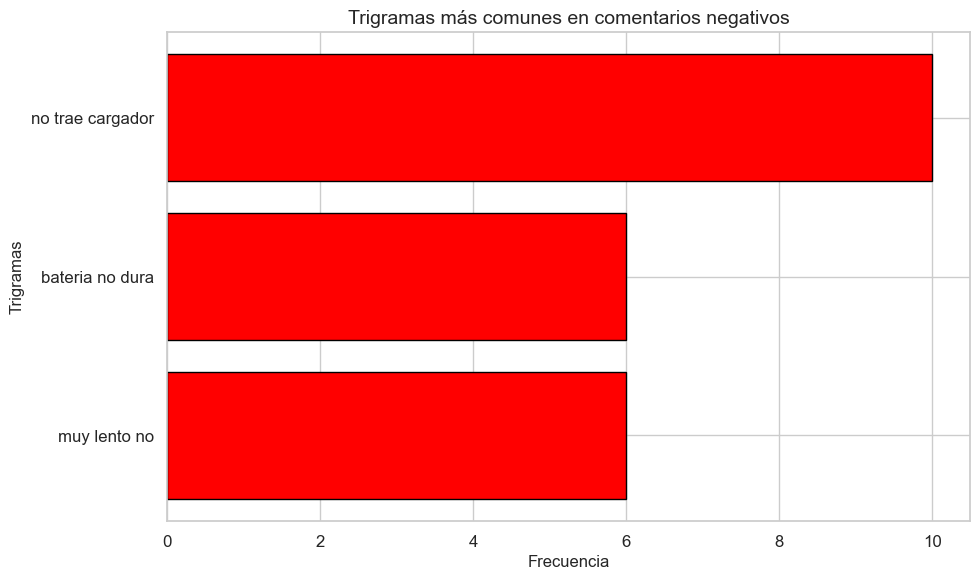

In [23]:
# Visualización: Trigramas negativos
plt.figure(figsize=(10, 6))
plt.barh(df_trigramas_negativos['Trigrama'].astype(str), df_trigramas_negativos['Frecuencia'], color='red', edgecolor='black')
plt.xlabel("Frecuencia", fontsize=12)
plt.ylabel("Trigramas", fontsize=12)
plt.title("Trigramas más comunes en comentarios negativos", fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()




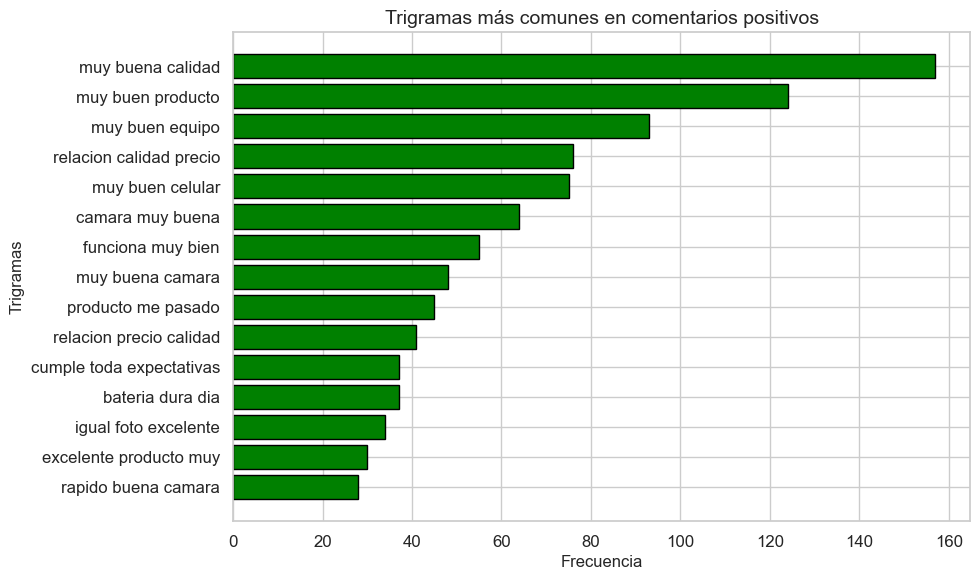

In [24]:
# Visualización: Trigramas positivos
plt.figure(figsize=(10, 6))
plt.barh(df_trigramas_positivos['Trigrama'].astype(str), df_trigramas_positivos['Frecuencia'], color='green', edgecolor='black')
plt.xlabel("Frecuencia", fontsize=12)
plt.ylabel("Trigramas", fontsize=12)
plt.title("Trigramas más comunes en comentarios positivos", fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Bigramas y Trigramas por Marca

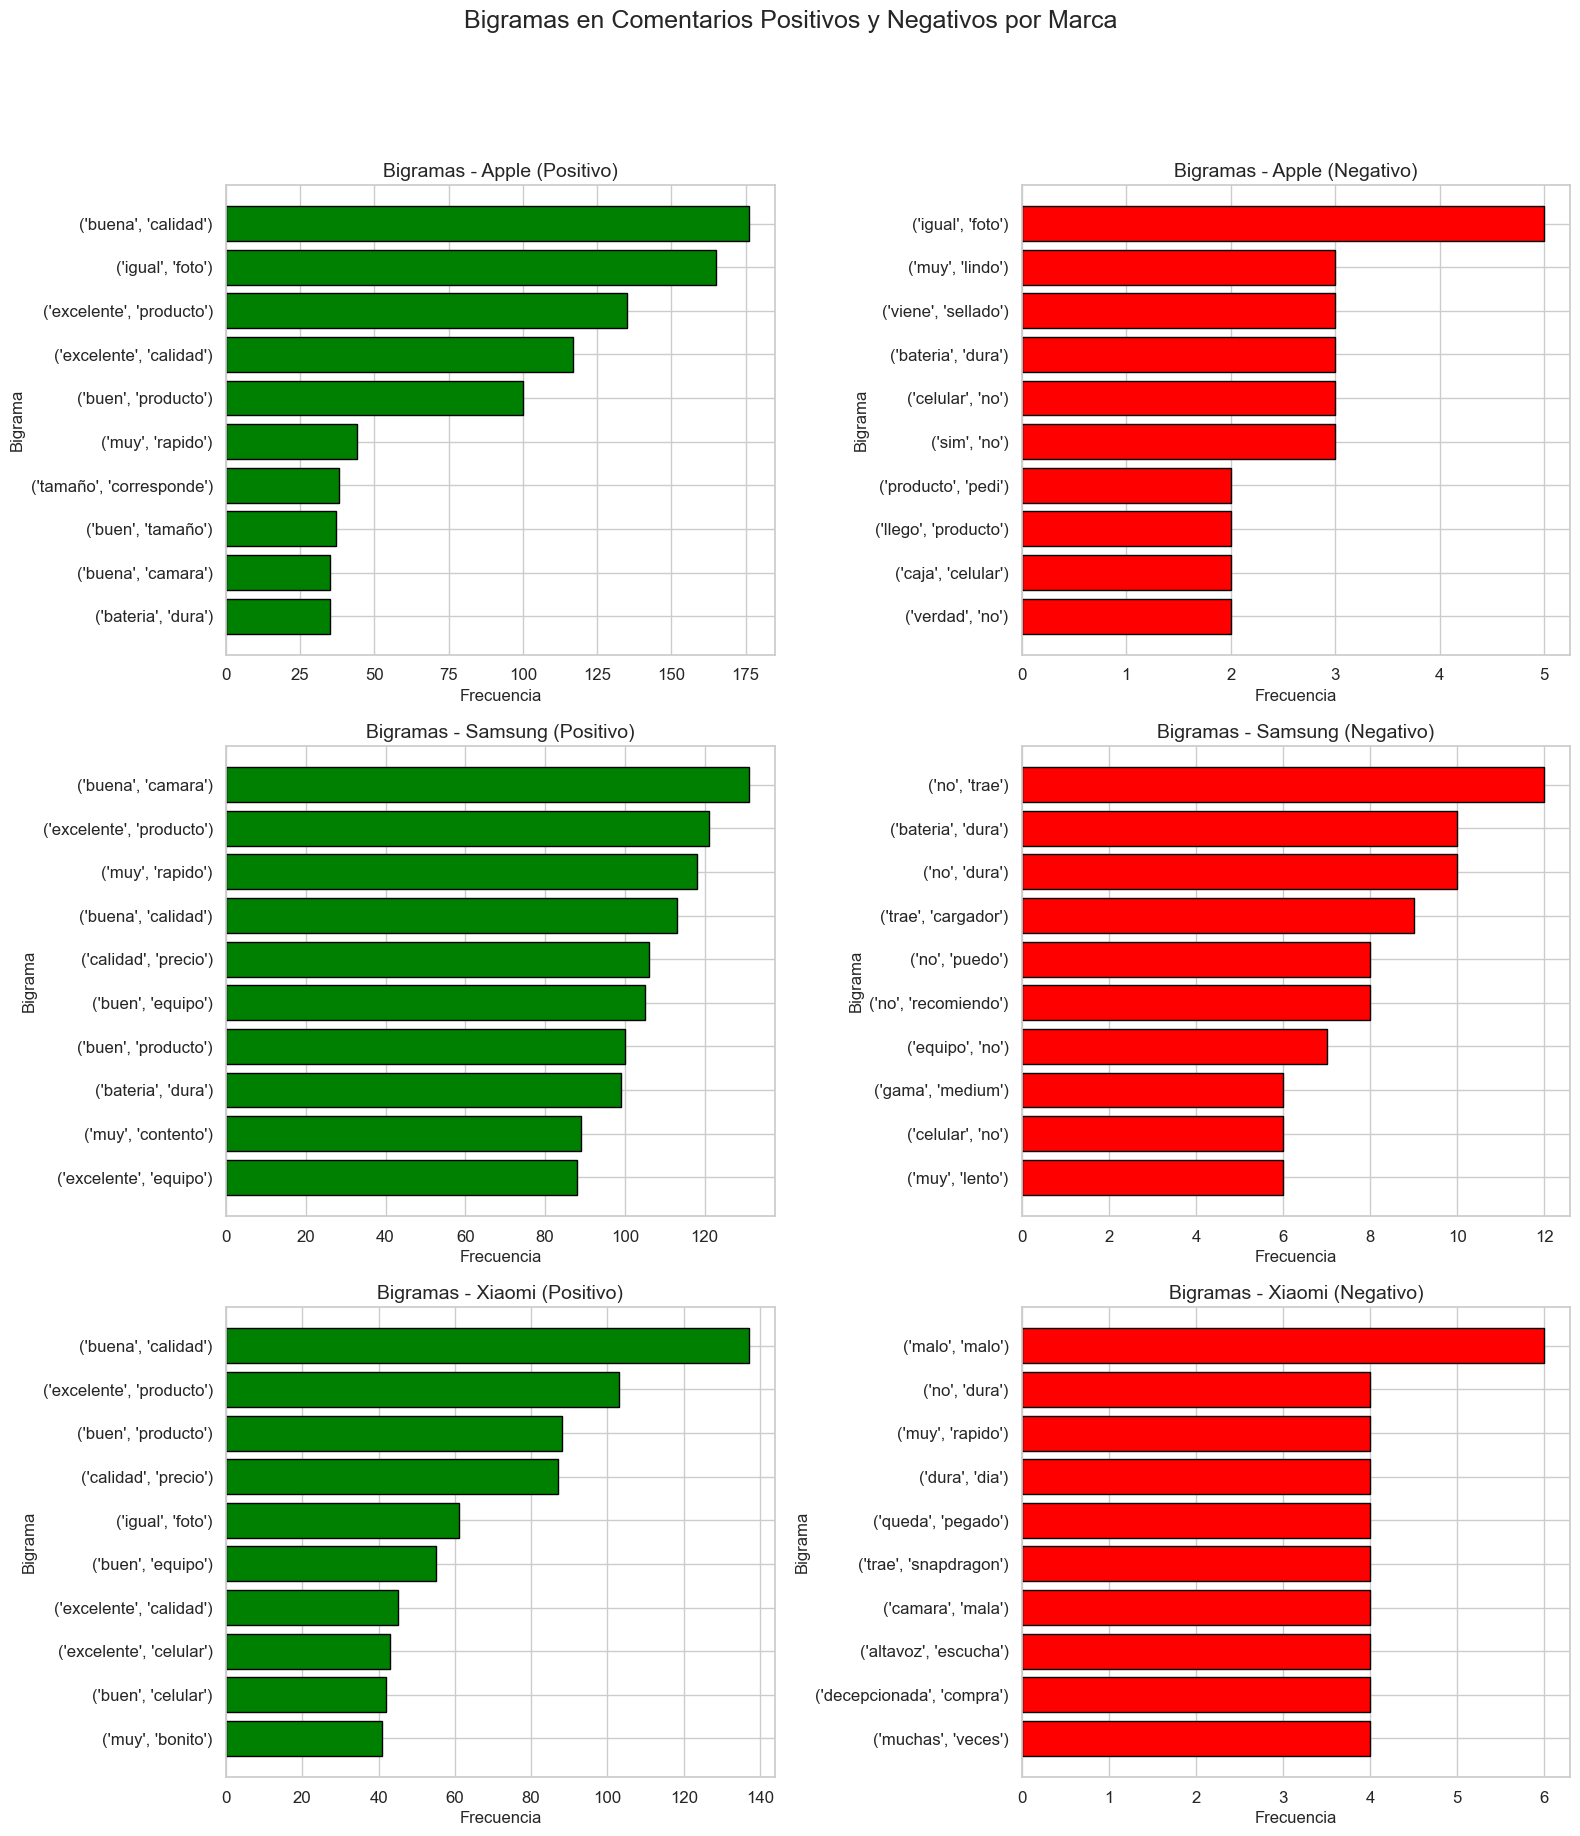

In [26]:
from nltk.util import ngrams

# Configuración de los gráficos
fig, axes = plt.subplots(len(marcas), 2, figsize=(16, len(marcas) * 6))  # 2 gráficos por marca (positivo/negativo)
fig.suptitle("Bigramas en Comentarios Positivos y Negativos por Marca", fontsize=18, y=1.02)

# Iterar sobre cada marca
for i, marca in enumerate(marcas):
    for j, sentimiento in enumerate(['Positivo', 'Negativo']):
        # Filtrar comentarios por marca y sentimiento
        comentarios_marca = df[(df['Marca'] == marca) & (df['Sentimiento'] == sentimiento)]['comentario_limpio']
        tokens_marca = [comentario.split() for comentario in comentarios_marca]

        # Generar bigramas con exclusión de palabras específicas
        bigramas_marca = [
            bigram for comentario in tokens_marca for bigram in ngrams(comentario, 2)
            if not any(palabra in excluir_bigramas_totales for palabra in bigram) and
               len(set(bigram) & set(excluir_bigramas_duplicados)) <= 1
        ]

        # Contar frecuencias
        frecuencias_bigramas = Counter(bigramas_marca).most_common(10)  # Top 10 bigramas

        # Crear DataFrame para graficar
        df_bigramas = pd.DataFrame(frecuencias_bigramas, columns=['Bigrama', 'Frecuencia'])

        # Graficar Bigramas
        ax = axes[i, j]
        ax.barh(df_bigramas['Bigrama'].astype(str), df_bigramas['Frecuencia'], color='green' if sentimiento == 'Positivo' else 'red', edgecolor='black')
        ax.set_title(f"Bigramas - {marca} ({sentimiento})", fontsize=14)
        ax.set_xlabel("Frecuencia", fontsize=12)
        ax.set_ylabel("Bigrama", fontsize=12)
        ax.invert_yaxis()

# Ajustar diseño general para evitar superposición
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


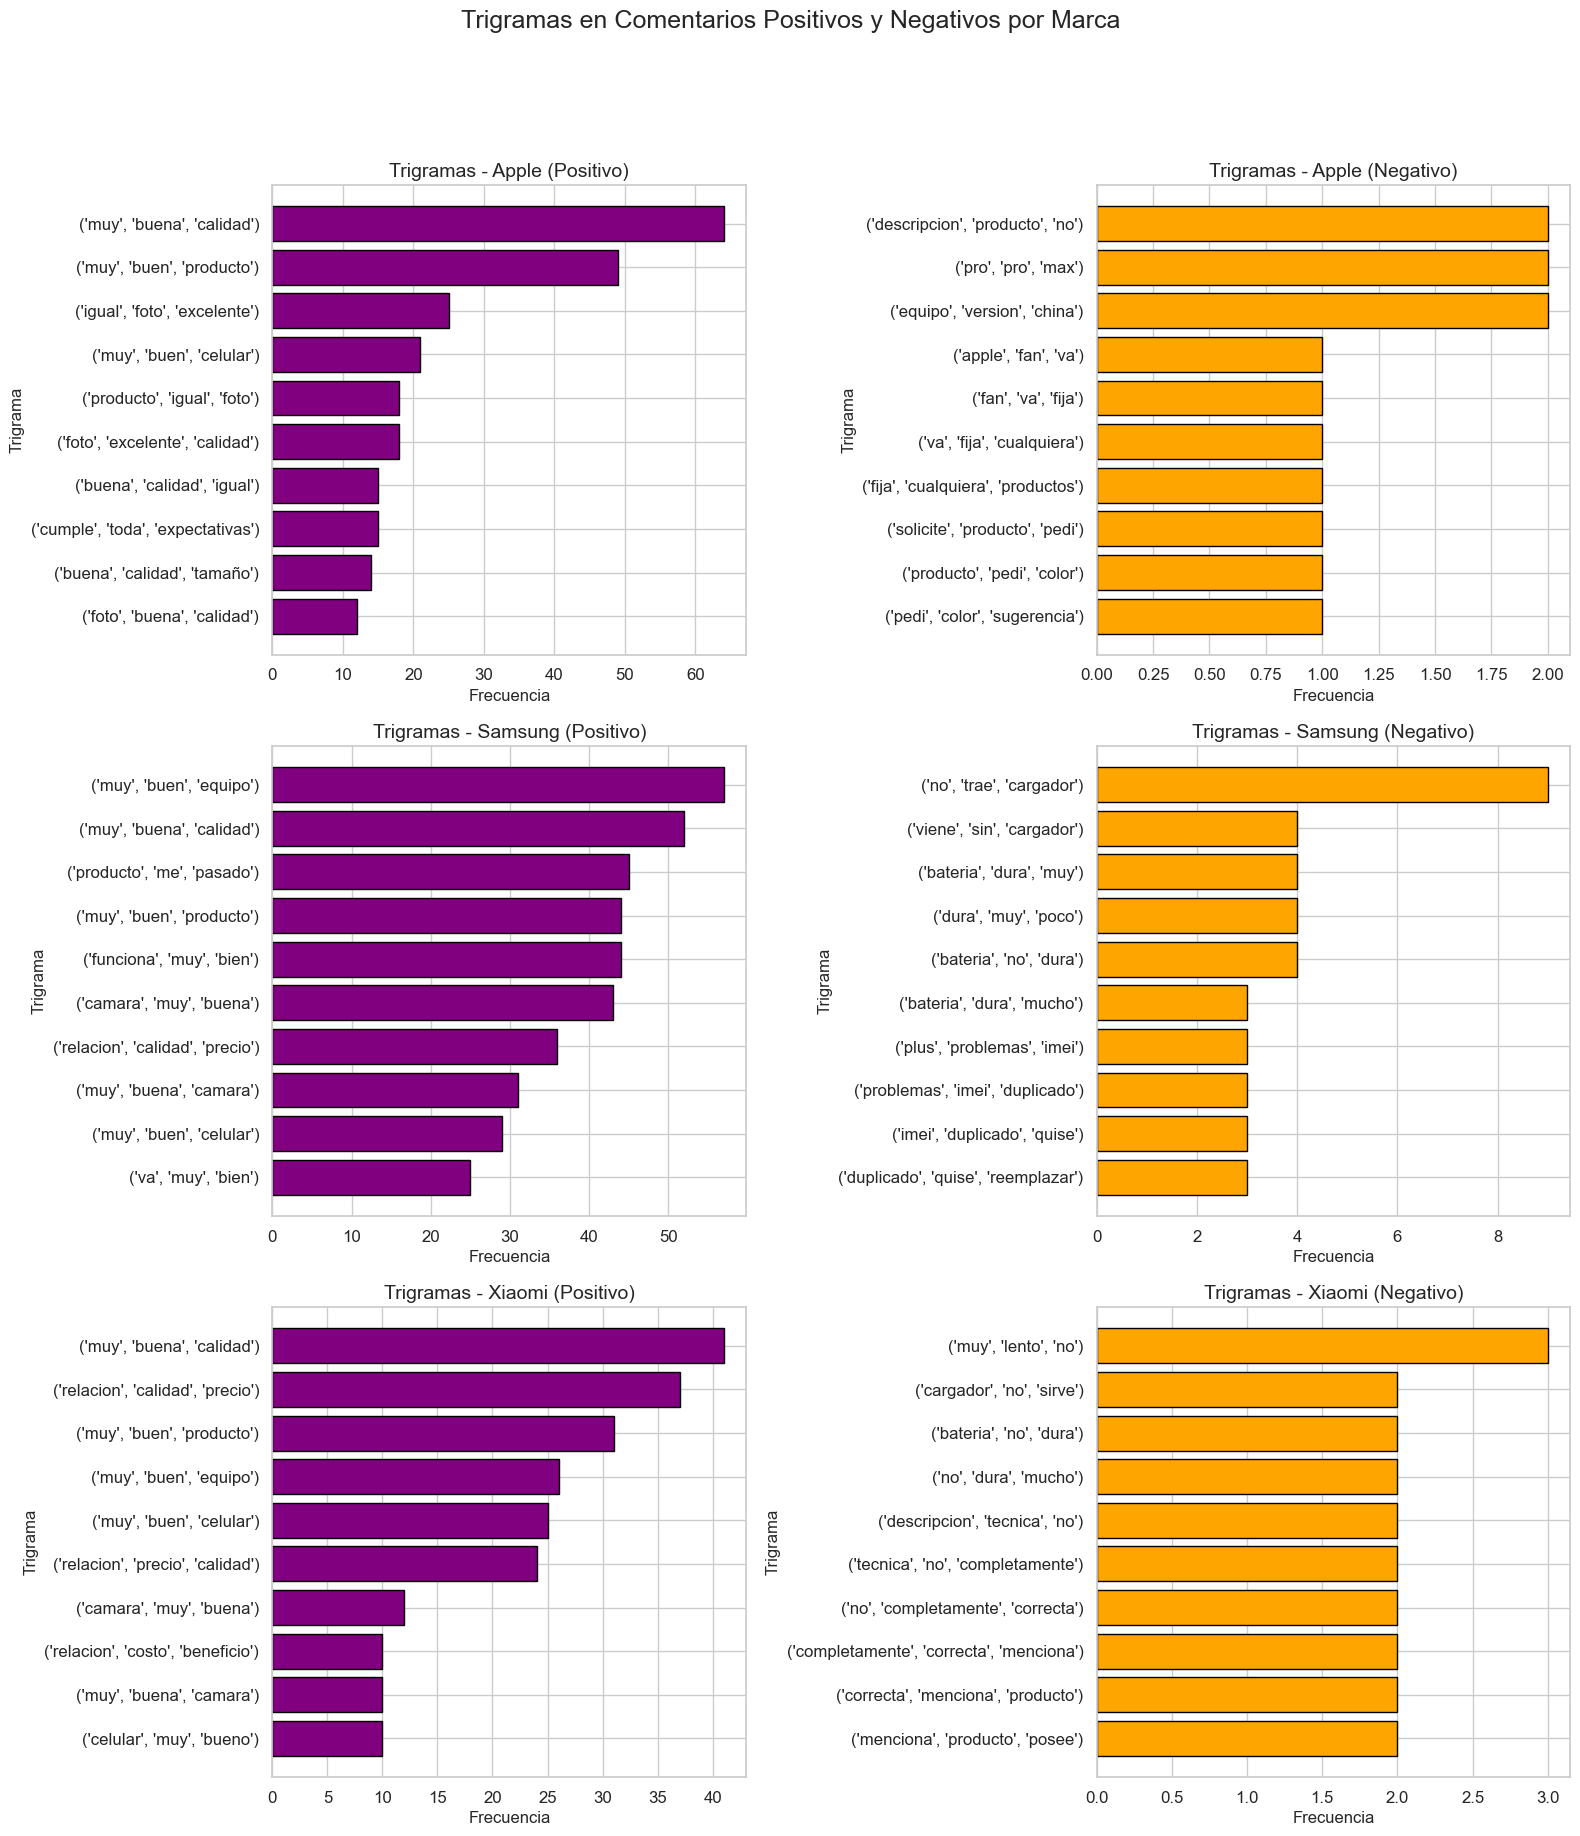

In [27]:
# Configuración de los gráficos
fig, axes = plt.subplots(len(marcas), 2, figsize=(16, len(marcas) * 6))  # 2 gráficos por marca (positivo/negativo)
fig.suptitle("Trigramas en Comentarios Positivos y Negativos por Marca", fontsize=18, y=1.02)

# Iterar sobre cada marca
for i, marca in enumerate(marcas):
    for j, sentimiento in enumerate(['Positivo', 'Negativo']):
        # Filtrar comentarios por marca y sentimiento
        comentarios_marca = df[(df['Marca'] == marca) & (df['Sentimiento'] == sentimiento)]['comentario_limpio']
        tokens_marca = [comentario.split() for comentario in comentarios_marca]

        # Generar trigramas con exclusión de palabras específicas
        trigramas_marca = [
            trigram for comentario in tokens_marca for trigram in ngrams(comentario, 3)
            if not any(palabra in excluir_bigramas_totales for palabra in trigram)
        ]

        # Contar frecuencias
        frecuencias_trigramas = Counter(trigramas_marca).most_common(10)  # Top 10 trigramas

        # Crear DataFrame para graficar
        df_trigramas = pd.DataFrame(frecuencias_trigramas, columns=['Trigrama', 'Frecuencia'])

        # Graficar Trigramas
        ax = axes[i, j]
        ax.barh(df_trigramas['Trigrama'].astype(str), df_trigramas['Frecuencia'], color='purple' if sentimiento == 'Positivo' else 'orange', edgecolor='black')
        ax.set_title(f"Trigramas - {marca} ({sentimiento})", fontsize=14)
        ax.set_xlabel("Frecuencia", fontsize=12)
        ax.set_ylabel("Trigrama", fontsize=12)
        ax.invert_yaxis()

# Ajustar diseño general para evitar superposición
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


4. Análisis de Temas (Topic Modeling)

In [19]:
df_as = df

In [ ]:
# Definir los temas y las palabras clave asociadas
temas = {
    "Cámara": [
        "cámara", "fotos", "fotografía", "frontal", "lente", "video", "calibracion",
        "fotografías", "grabación", "selfie", "zoom", "ángulo", "nitidez", "flash",
        "exposición", "foco", "captura", "enfoca"
    ],
    "Batería": [
        "batería", "carga", "cargador", "dura", "energía", "duración", "cargar", 
        "inalámbrica", "powerbank", "sobrecarga", "sobrecalentamiento", "voltaje", "descarga", "rendimiento de batería"
    ],
    "Precio": [
        "precio", "caro", "barato", "costo", "económico", "inversión", "vale", "asequible", 
        "promoción", "oferta", "calidad-precio", "rebaja", "accesible", "cuesta", "dinero", "valor", "gasto", "compensación"
    ],
    "Rendimiento": [
        "traba", "buggea", "ram", "queda pegado", "congelado", "corre", "recalienta", "Google", "facebook", "redes sociales",
        "rendimiento", "rápido", "fluido", "lento", "procesador", "eficiencia", "memoria", 
        "potencia", "velocidad", "multitarea", "procesos", "aplicaciones",
        "juegos", "optimización", "frecuencia", "capacidad", "retraso", "lag", "software"
    ],
    "Pantalla": [
        "pantalla", "brillo", "visualización", "display", "imagen", "tactil", #"tamaño",
        "OLED", "LCD", "AMOLED", "táctil", "refresco", "frecuencia"
    ]
}

# Definir frases de exclusión para palabras ambiguas
exclusiones = {
    "fotos": ["igual a las fotos", "fiel a las fotos", "igual al de las fotos",  "como en las fotos", "identico a las fotos", "a las fotos", "a la fotos"]
}

# Función para asignar temas con exclusión de contextos específicos
def asignar_tema(comentario, temas, exclusiones):
    comentario_temas = []
    for tema, palabras_clave in temas.items():
        for palabra in palabras_clave:
            # Verificar si la palabra está en el comentario
            if re.search(rf"\b{re.escape(palabra)}\b", comentario, re.IGNORECASE):
                # Aplicar la regla de exclusión
                excluir = False
                if palabra in exclusiones:
                    for frase_exclusion in exclusiones[palabra]:
                        if frase_exclusion in comentario:
                            excluir = True
                            break
                if not excluir:
                    comentario_temas.append(tema)
                    break  # Evita asignar el mismo tema varias veces
    return comentario_temas

# Asignar temas a cada comentario en la columna 'comentario_limpio'
df_as['Temas'] = df_as['comentario_limpio'].apply(lambda x: asignar_tema(x, temas, exclusiones))

# Expandir los temas en filas separadas para un análisis más fácil
df_tematicos = df_as.explode('Temas')

# Calcular métricas por tema y marca
resultados = df_tematicos.groupby(['Marca', 'Temas']).agg(
    Total_Comentarios=('comentario', 'count'),
    Calificacion_Promedio=('Calificacion Predicha', 'mean')
).reset_index()

# Ordenar los resultados por marca y tema
resultados = resultados.sort_values(['Marca', 'Temas'])

# Mostrar los resultados
print(resultados)

# Opcional: Exportar el DataFrame df_as como un archivo CSV

# Reemplazar saltos de línea (\n y \r) con un espacio
df_as['comentario'] = df_as['comentario'].str.replace(r'\r\n|\r|\n', ' ', regex=True)
df_as['comentario_limpio'] = df_as['comentario_limpio'].str.replace(r'\r\n|\r|\n', ' ', regex=True)
df_as['comentario_limpio_sin_lematizar'] = df_as['comentario_limpio_sin_lematizar'].str.replace(r'\r\n|\r|\n', ' ', regex=True)

df_as.to_csv("D:/Documents/Scrapping Sentimientos Project/Project_repository/Analisis de Sentimientos/df_temas.csv", 
             index=False, encoding='utf-8')

      Marca        Temas  Total_Comentarios  Calificacion_Promedio
0     Apple      Batería                 89               4.022472
1     Apple       Cámara                 75               4.640000
2     Apple     Pantalla                 63               4.650794
3     Apple       Precio                171               4.678363
4     Apple  Rendimiento                 98               4.540816
5   Samsung      Batería                390               3.874359
6   Samsung       Cámara                452               4.544248
7   Samsung     Pantalla                476               4.441176
8   Samsung       Precio                428               4.504673
9   Samsung  Rendimiento                757               4.482166
10   Xiaomi      Batería                209               4.000000
11   Xiaomi       Cámara                 88               4.136364
12   Xiaomi     Pantalla                104               4.038462
13   Xiaomi       Precio                325               4.52

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19524\1642706447.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Temas'] = df['comentario_limpio'].apply(lambda x: asignar_tema(x, temas, exclusiones))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19524\1642706447.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Temas'] = df['comentario_limpio'].apply(lambda x: asignar_tema(x, temas, exclusiones))


Gráfico Normalizado para Comentarios Positivos


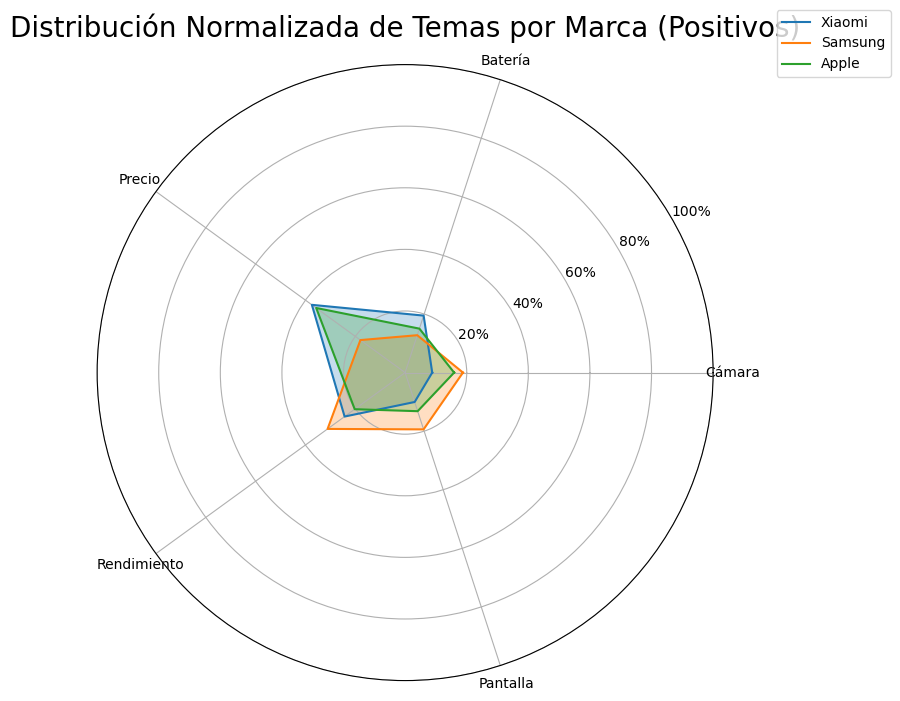

Gráfico Normalizado para Comentarios Negativos


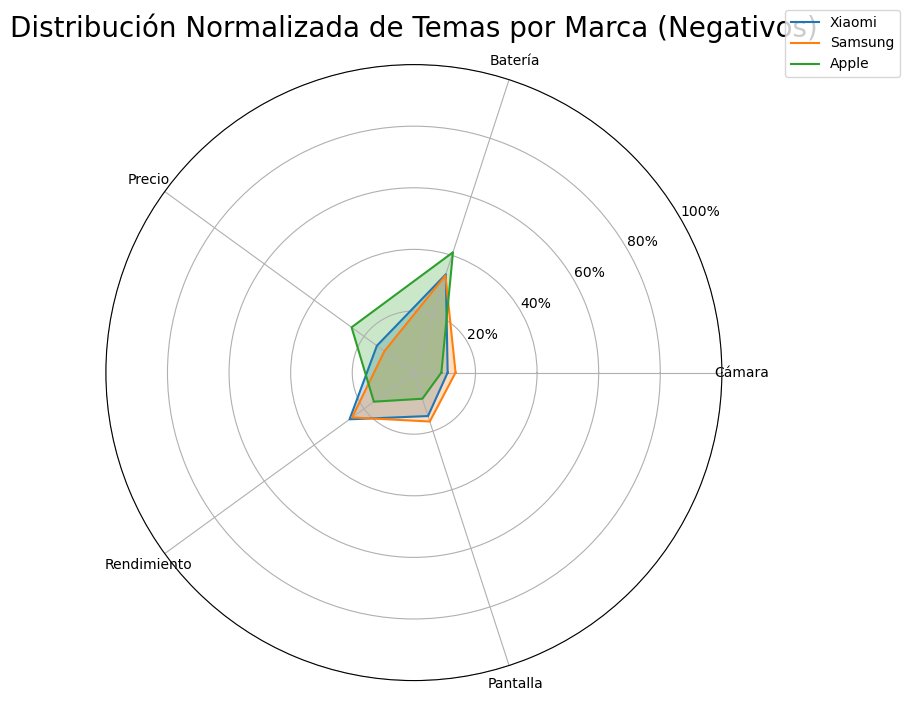

Datos para Comentarios Positivos:
    Marca         Tema  Porcentaje_Normalizado
0  Xiaomi       Cámara                    8.80
1  Xiaomi      Batería                   19.45
2  Xiaomi       Precio                   37.42
3  Xiaomi  Rendimiento                   24.29
4  Xiaomi     Pantalla                   10.04
Datos para Comentarios Negativos:
    Marca         Tema  Porcentaje_Normalizado
0  Xiaomi       Cámara                   10.97
1  Xiaomi      Batería                   33.55
2  Xiaomi       Precio                   14.84
3  Xiaomi  Rendimiento                   25.81
4  Xiaomi     Pantalla                   14.84


In [21]:
# Función para asignar temas con exclusiones
def asignar_tema(comentario, temas, exclusiones={}):
    comentario_temas = []
    for tema, palabras_clave in temas.items():
        for palabra in palabras_clave:
            if re.search(rf"\b{re.escape(palabra)}\b", comentario, re.IGNORECASE):
                # Aplicar la regla de exclusión
                excluir = False
                if palabra in exclusiones:
                    for frase_exclusion in exclusiones[palabra]:
                        if frase_exclusion in comentario:
                            excluir = True
                            break
                if not excluir:
                    comentario_temas.append(tema)
                    break
    return comentario_temas

# Dividir el DataFrame en positivos y negativos
positivos = df_as[df_as['Calificacion Predicha'] > 3]
negativos = df_as[df_as['Calificacion Predicha'] <= 3]

# Función para calcular el conteo de temas por marca
def calcular_temas_por_marca(df, temas, exclusiones={}):
    # Asignar temas a cada comentario
    df['Temas'] = df['comentario_limpio'].apply(lambda x: asignar_tema(x, temas, exclusiones))
    
    # Expandir los temas en filas separadas
    df_tematicos = df.explode('Temas')
    
    # Calcular el total de comentarios por tema y marca
    resultados = df_tematicos.groupby(['Marca', 'Temas']).size().reset_index(name='Total_Comentarios')
    return resultados

# Calcular temas por marca para positivos y negativos (sin exclusiones)
temas_positivos = calcular_temas_por_marca(positivos, temas, {})
temas_negativos = calcular_temas_por_marca(negativos, temas, {})

# Función para preparar y exportar los datos normalizados para gráficos de radar
def preparar_datos_radar_normalizado_exportar(resultados, marcas, temas):
    radar_data = {}
    data_list = []  # Lista para almacenar filas del DataFrame
    
    for marca in marcas:
        marca_data = resultados[ resultados['Marca'] == marca ]
        total_comentarios = marca_data['Total_Comentarios'].sum()  # Total de comentarios de la marca
        valores = []
        for tema in temas.keys():
            total = marca_data[marca_data['Temas'] == tema]['Total_Comentarios'].sum()
            porcentaje = round((total / total_comentarios) * 100, 2) if total_comentarios > 0 else 0  # Normalizar con 2 decimales
            valores.append(porcentaje)
            
            # Agregar fila al DataFrame con valores normalizados
            data_list.append({'Marca': marca, 'Tema': tema, 'Porcentaje_Normalizado': porcentaje})
        
        radar_data[marca] = valores

    # Crear DataFrame con los resultados
    df_radar = pd.DataFrame(data_list)
    return radar_data, df_radar

# Preparar los datos normalizados para gráficos y exportar como DataFrame
marcas = df_as['Marca'].unique()
radar_positivos_normalizado, df_positivos = preparar_datos_radar_normalizado_exportar(temas_positivos, marcas, temas)
radar_negativos_normalizado, df_negativos = preparar_datos_radar_normalizado_exportar(temas_negativos, marcas, temas)

# Exportar los DataFrames a archivos CSV
df_positivos.to_csv("D:/Documents/Scrapping Sentimientos Project/Project_repository/Analisis de Sentimientos/comentarios_positivos_radar.csv", index=False, encoding='utf-8')
df_negativos.to_csv("D:/Documents/Scrapping Sentimientos Project/Project_repository/Analisis de Sentimientos/comentarios_negativos_radar.csv", index=False, encoding='utf-8')

# Función para graficar radar charts normalizados
def graficar_radar_normalizado(data, temas, titulo):
    categorias = list(temas.keys())
    N = len(categorias)

    # Ángulo de cada eje
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Cerrar el círculo

    # Crear subgráficos
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for marca, valores in data.items():
        valores += valores[:1]  # Cerrar el círculo
        ax.plot(angles, valores, label=marca)
        ax.fill(angles, valores, alpha=0.25)

    # Configuración del gráfico
    ax.set_title(titulo, size=20, pad=20)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categorias)
    ax.set_rlabel_position(30)
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_yticklabels(["20%", "40%", "60%", "80%", "100%"])
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    plt.show()

# Graficar radar charts normalizados
print("Gráfico Normalizado para Comentarios Positivos")
graficar_radar_normalizado(radar_positivos_normalizado, temas, "Distribución Normalizada de Temas por Marca (Positivos)")

print("Gráfico Normalizado para Comentarios Negativos")
graficar_radar_normalizado(radar_negativos_normalizado, temas, "Distribución Normalizada de Temas por Marca (Negativos)")

# Mostrar los DataFrames generados
print("Datos para Comentarios Positivos:")
print(df_positivos.head())

print("Datos para Comentarios Negativos:")
print(df_negativos.head())

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19524\8890656.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Temas'] = df['comentario_limpio'].apply(lambda x: asignar_tema(x, temas, exclusiones))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19524\8890656.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Temas'] = df['comentario_limpio'].apply(lambda x: asignar_tema(x, temas, exclusiones))


Gráfico Normalizado para Comentarios Positivos - Xiaomi


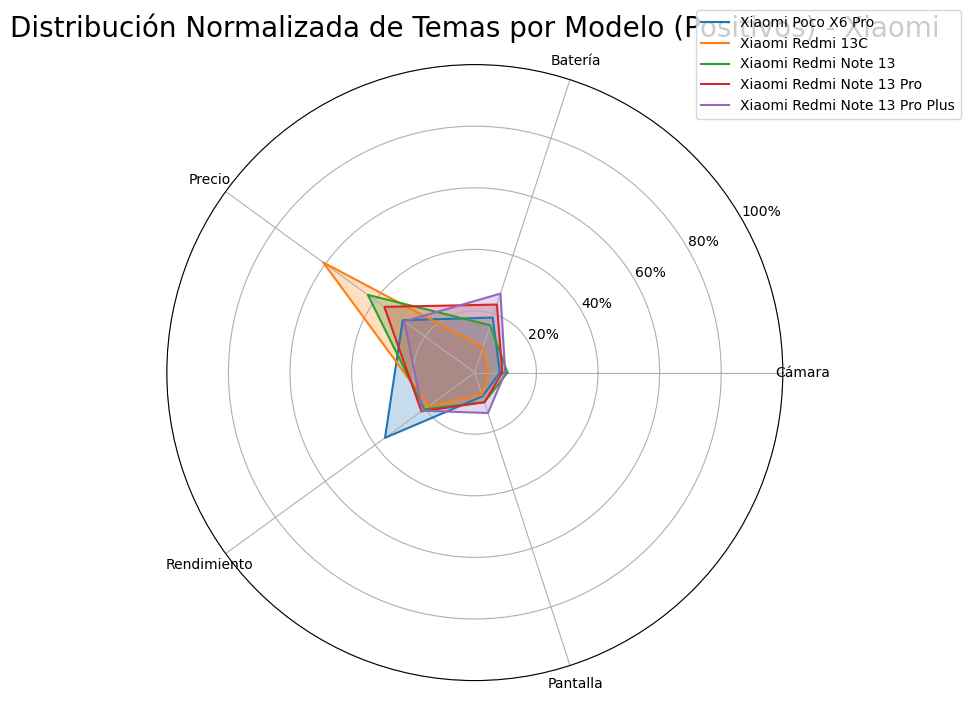

Gráfico Normalizado para Comentarios Negativos - Xiaomi


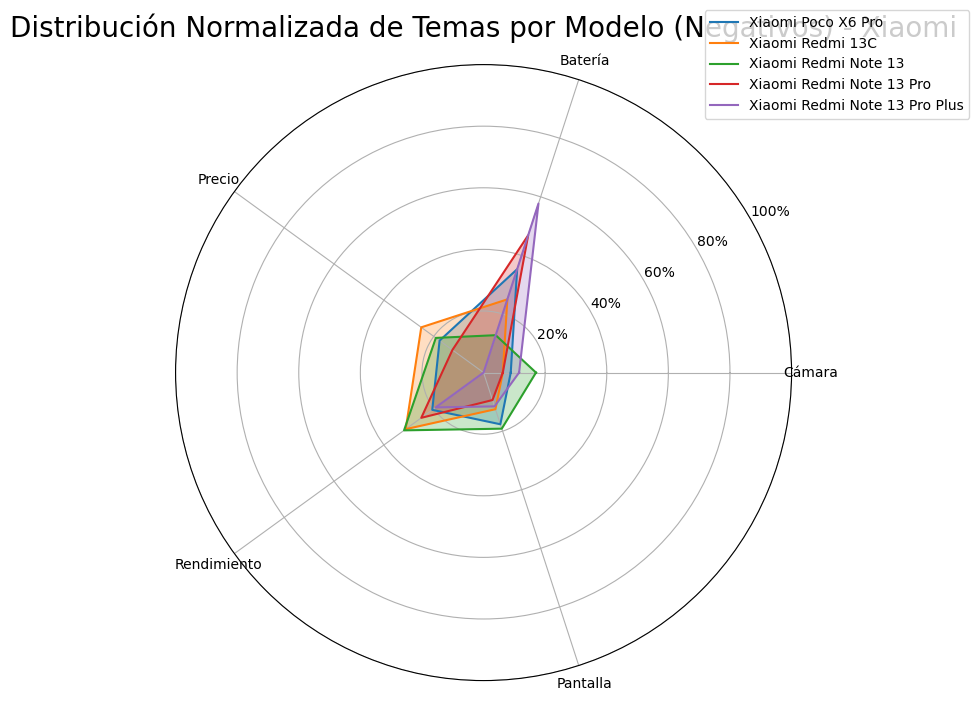

Gráfico Normalizado para Comentarios Positivos - Samsung


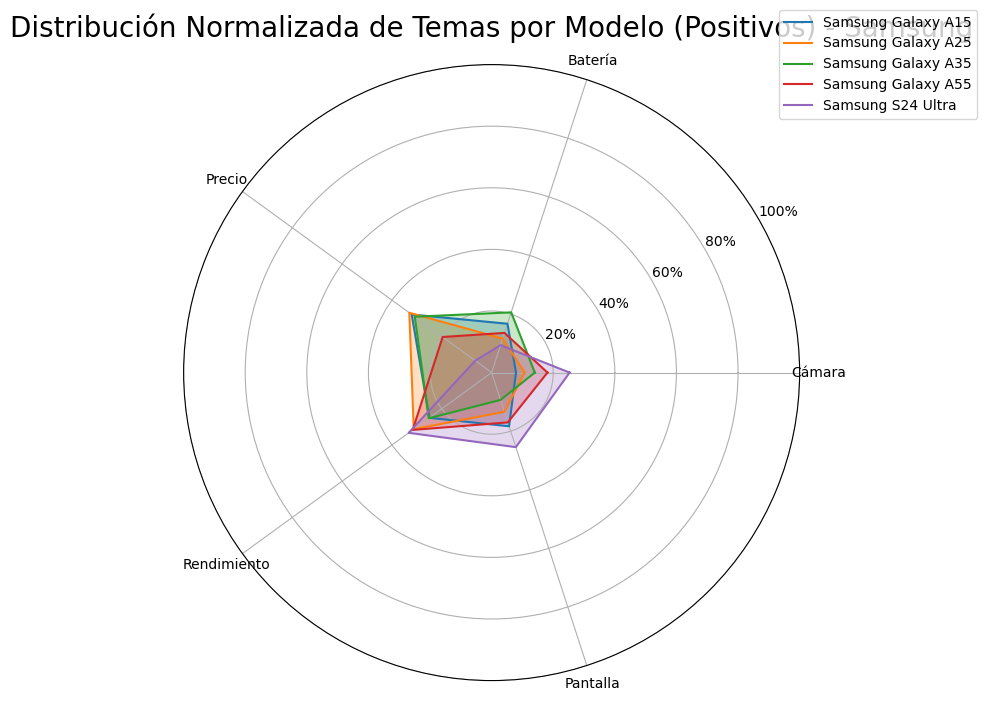

Gráfico Normalizado para Comentarios Negativos - Samsung


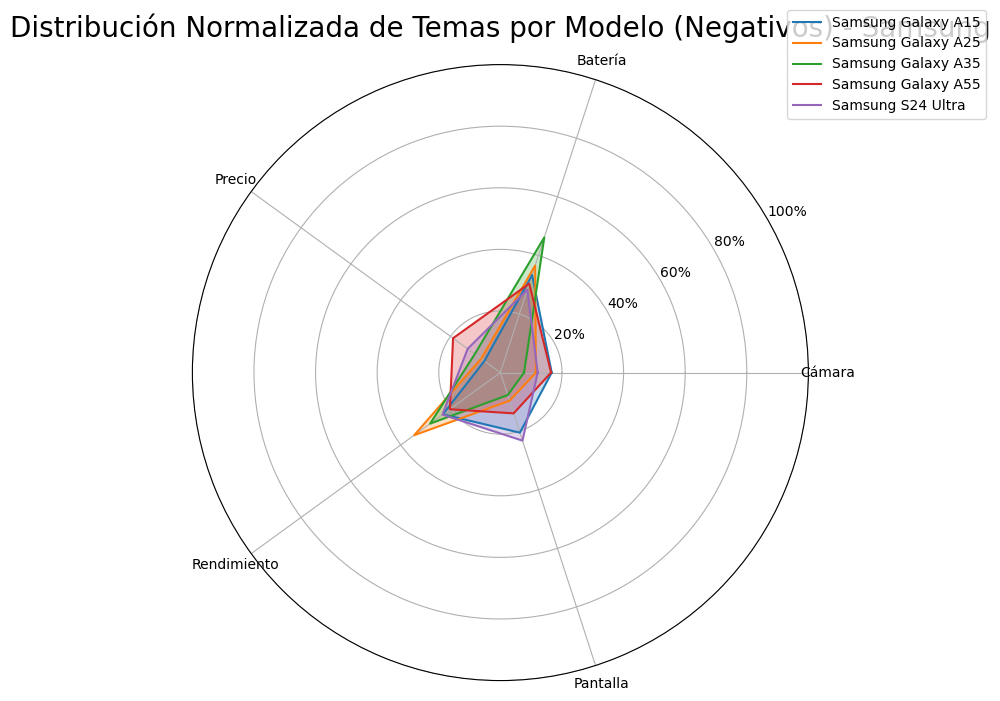

Gráfico Normalizado para Comentarios Positivos - Apple


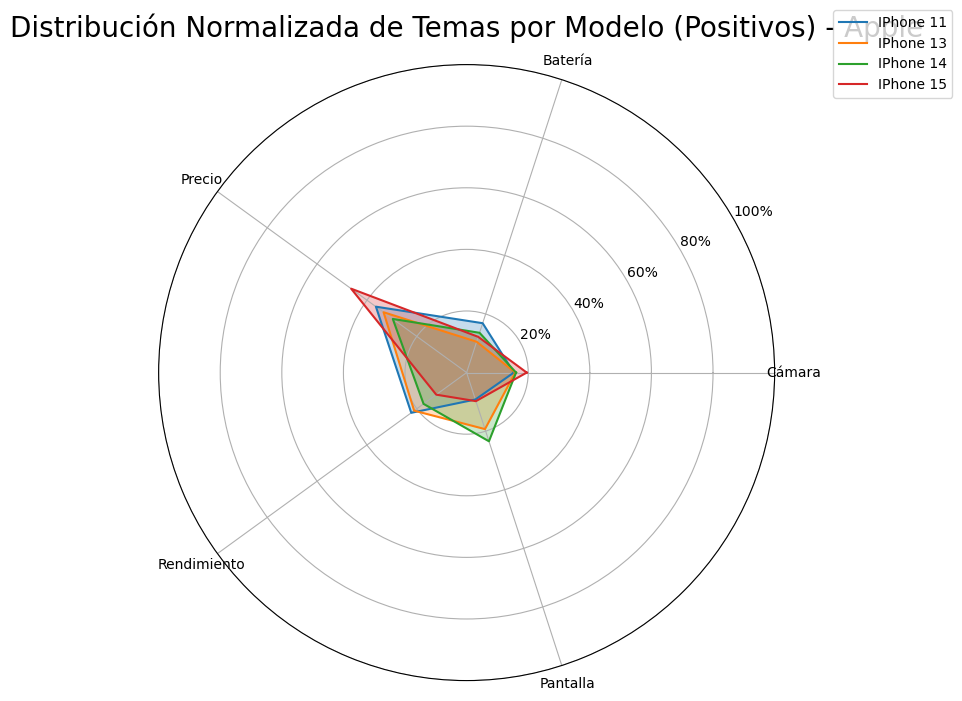

Gráfico Normalizado para Comentarios Negativos - Apple


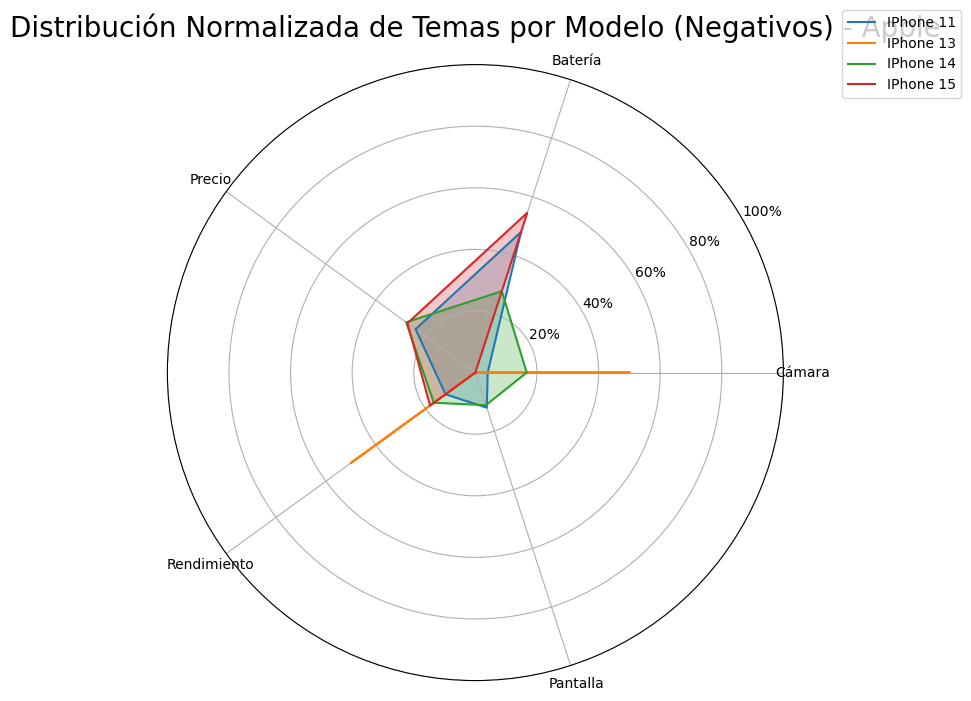

In [23]:
# Función para asignar temas con exclusiones
def asignar_tema(comentario, temas, exclusiones={}):
    comentario_temas = []
    for tema, palabras_clave in temas.items():
        for palabra in palabras_clave:
            if re.search(rf"\b{re.escape(palabra)}\b", comentario, re.IGNORECASE):
                excluir = False
                if palabra in exclusiones:
                    for frase_exclusion in exclusiones[palabra]:
                        if frase_exclusion in comentario:
                            excluir = True
                            break
                if not excluir:
                    comentario_temas.append(tema)
                    break
    return comentario_temas

# Función para calcular el conteo de temas por modelo
def calcular_temas_por_modelo(df, temas, exclusiones={}):
    df['Temas'] = df['comentario_limpio'].apply(lambda x: asignar_tema(x, temas, exclusiones))
    df_tematicos = df.explode('Temas')
    resultados = df_tematicos.groupby(['Marca', 'Modelo estandar', 'Temas']).size().reset_index(name='Total_Comentarios')
    return resultados

# Función para preparar datos para gráficos y exportación
def preparar_datos_radar_y_exportar(resultados, marca, temas):
    radar_data = {}
    data_list = []

    resultados_marca = resultados[resultados['Marca'] == marca]
    modelos = resultados_marca['Modelo estandar'].unique()

    for modelo in modelos:
        modelo_data = resultados_marca[resultados_marca['Modelo estandar'] == modelo]
        total_comentarios = modelo_data['Total_Comentarios'].sum()
        valores = []
        for tema in temas.keys():
            total = modelo_data[modelo_data['Temas'] == tema]['Total_Comentarios'].sum()
            porcentaje = round((total / total_comentarios) * 100, 2) if total_comentarios > 0 else 0
            valores.append(porcentaje)
            data_list.append({'Marca': marca, 'Modelo': modelo, 'Tema': tema, 'Porcentaje_Normalizado': porcentaje})

        radar_data[modelo] = valores

    df_radar = pd.DataFrame(data_list)
    return radar_data, df_radar

# Función para graficar radar charts
def graficar_radar_modelos(data, temas, titulo, marca):
    categorias = list(temas.keys())
    N = len(categorias)

    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for modelo, valores in data.items():
        valores += valores[:1]
        ax.plot(angles, valores, label=modelo)
        ax.fill(angles, valores, alpha=0.25)

    ax.set_title(f"{titulo} - {marca}", size=20, pad=20)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categorias)
    ax.set_rlabel_position(30)
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_yticklabels(["20%", "40%", "60%", "80%", "100%"])
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    plt.show()

# Dividir el DataFrame en positivos y negativos usando 'Calificacion Predicha'
positivos = df_as[df_as['Calificacion Predicha'] > 3]
negativos = df_as[df_as['Calificacion Predicha'] <= 3]

# Calcular temas por modelo
temas_positivos = calcular_temas_por_modelo(positivos, temas, {})
temas_negativos = calcular_temas_por_modelo(negativos, temas, {})

# Preparar datos para gráficos y exportar
df_positivos_modelos = []
df_negativos_modelos = []

for marca in df_as['Marca'].unique():
    # Preparar datos para positivos
    radar_positivos_marca, df_positivos_marca = preparar_datos_radar_y_exportar(temas_positivos, marca, temas)
    radar_negativos_marca, df_negativos_marca = preparar_datos_radar_y_exportar(temas_negativos, marca, temas)
    
    # Agregar a la lista para concatenar después
    df_positivos_modelos.append(df_positivos_marca)
    df_negativos_modelos.append(df_negativos_marca)
    
    # Graficar para comentarios positivos
    print(f"Gráfico Normalizado para Comentarios Positivos - {marca}")
    graficar_radar_modelos(radar_positivos_marca, temas, "Distribución Normalizada de Temas por Modelo (Positivos)", marca)
    
    # Graficar para comentarios negativos
    print(f"Gráfico Normalizado para Comentarios Negativos - {marca}")
    graficar_radar_modelos(radar_negativos_marca, temas, "Distribución Normalizada de Temas por Modelo (Negativos)", marca)

# Concatenar los DataFrames y exportar
df_positivos_modelos = pd.concat(df_positivos_modelos, ignore_index=True)
df_negativos_modelos = pd.concat(df_negativos_modelos, ignore_index=True)

df_positivos_modelos.to_csv("comentarios_positivos_modelos_radar.csv", index=False, encoding='utf-8')
df_negativos_modelos.to_csv("comentarios_negativos_modelos_radar.csv", index=False, encoding='utf-8')

# Mostrar los DataFrames generados
print("Datos para Comentarios Positivos por Modelo:")
print(df_positivos_modelos.head())

print("Datos para Comentarios Negativos por Modelo:")
print(df_negativos_modelos.head())

In [ ]:
#Guardar df en un archivo CSV
df_as.to_csv("../Analisis de Sentimientos/sentiment_analysis.csv", index=False)